### План:

**1) Загрузка данных с Excel файлов, сформированных на предыдущем этапе.**

**2) Прогноз притока по осадкам (при необходимсоти гридсерч).**

**3) Прогноз сброса по притоку и метрикам ГЭС за предыдущий месяц.**

# Этап 1

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime as dt
import os #Для получения списка файлов и определения самого последнего из них по названию

today = dt.now();
current_date = str(dt.now())[:10];

'Целевые переменные'

Приток_IRK  Приток_SHA   Приток_KRA   Приток_BRA   Приток_UIM  \
Дата                                                                         
2021-12-01  -158.333333  515.161290  1547.391304  2619.666667  5479.133333   
2022-01-01   539.285714  457.741935  1499.032258  2271.935484  3928.064516   
2022-02-01   530.357143  418.928571  1385.714286  1726.964286  3327.500000   
2022-03-01   359.354839  408.709677  2205.483871  2235.967742  3222.709677   
2022-04-01  1120.000000  665.200000  2548.695652  3010.800000  3215.480000   

             Приток_BOG    Сброс_IRK    Сброс_SHA    Сброс_KRA    Сброс_BRA  \
Дата                                                                          
2021-12-01  3431.129032  2281.333333  1210.290323  3581.304348  5479.133333   
2022-01-01  3641.096774  2032.903226  1209.677419  2416.129032  3928.064516   
2022-02-01  3830.142857  1539.285714  1153.571429  2311.428571  3327.500000   
2022-03-01  3640.645161  2056.612903  1457.129032  2314.838710  3222.709677   
2022-04-01  3569.000000  2436.400000  1415.960000  2223.913043  3215.480000   

              Сброс_UIM    Сброс_BOG  Уровень_IRK  Уровень_SHA  Уровень_KRA  \
Дата                                                                          
2021-12-01  3391.966667  3702.548387       456.80       527.55       234.66   
2022-01-01  3714.516129  3538.709677       456.67       522.81       233.07   
2022-02-01  3792.500000  3980.357143       456.59       517.20       231.62   
2022-03-01  3528.548387  3834.838710       456.49       508.39       230.83   
2022-04-01  3543.400000  3686.920000       456.38       500.27       231.16   

            Уровень_BRA  Уровень_UIM  Уровень_BOG  
Дата                                               
2021-12-01       401.37       295.66       207.48  
2022-01-01       400.38       295.81       207.62  
2022-02-01       399.55       295.40       207.54  
2022-03-01       399.17       294.88       207.18  
2022-04-01       399.36       294.57       207.04

'Осадки условный факт'

Sec_1     Sec_4     Sec_7     Sec_2     Sec_5     Sec_8  \
Дата                                                                     
2011-04-01  2.012622  2.939132  2.932266  1.577565  2.219814  2.720679   
2011-05-01  2.568805  3.163305  2.623750  2.431211  2.286903  2.106027   
2011-06-01  3.245659  3.099077  2.369655  3.503265  2.409096  1.861998   
2011-07-01  3.281641  2.978100  2.611867  4.182706  3.073458  2.003827   
2011-08-01  2.870426  3.029378  2.483132  3.288112  2.857665  2.060219   

               Sec_3     Sec_6     Sec_9  
Дата                                      
2011-04-01  1.000742  1.810167  3.008710  
2011-05-01  1.689381  2.941815  2.786787  
2011-06-01  2.122602  3.060808  3.028305  
2011-07-01  3.197671  4.074067  3.316473  
2011-08-01  3.036709  3.964651  3.515604

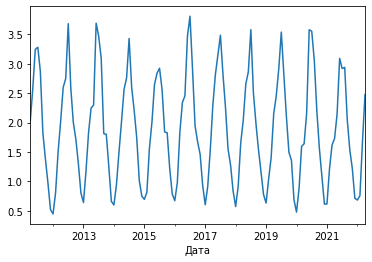

In [2]:
#Соханим словарь названий ГЭС, чтобы в дальнейшем было нагляднее где какая ГЭС
GES_name = {'IRK': 'Иркутская ГЭС', 'SHA': 'Саяно-Шушенская ГЭС', 'KRA': 'Красноярская ГЭС',
            'BRA': 'Братская ГЭС', 'UIM': 'Усть-Илимская ГЭС', 'BOG': 'Богучанская ГЭС'};

#Узнаем дату с последним сохранением файлов после выполнение блокнота №1
date_data_model = max([i[:10] for i in os.listdir('../data/Исходные данные/Показатели ГЭС/Свод после обработки/') if 'Графики' not in i]);

#Загрузим данные
target = pd.read_excel(f'../data/Исходные данные/Показатели ГЭС/Свод после обработки/{date_data_model} Целевые переменные.xlsx', index_col=0, header=0); #Притоки, сбросы, уровни
target.index = pd.to_datetime(target.index.astype(str), yearfirst=True); #При загрузке данные у индекса не самый удобный тип данных - поменяем
ml_fact = pd.read_excel(f'../data/Исходные данные/Данные с сайта IRI/{date_data_model} IRI факт.xlsx', index_col=0, header=0); #Условно фактические осадки

GES_pritok = [i for i in target.columns if 'Приток' in i];
GES_sbros = [i for i in target.columns if 'Сброс' in i];
GES_uroven = [i for i in target.columns if 'Уровень' in i];

display('Целевые переменные', target.tail(), 'Осадки условный факт', ml_fact.head());
ml_fact['Sec_1'].plot();

# CatBoost

In [3]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [4]:
def score_my(t, f):
    """
    Метрики для оценки модели.
    """
    return ("""RMSE: %.2f%%, %.4f; MAE: %.2f%%, %.4f"""
            % (mse(t, f)**0.5/t.mean()*100, mse(t, f)**0.5,
               mae(t, f)/t.mean()*100, mae(t, f)))

### Этап 2
Прогноз притока

In [5]:
#Соберем данные
#Добавим дополнительные фичи и целевую переменную
df_pritok = pd.concat([ml_fact,
                       ml_fact.rolling(4, min_periods=0).mean().add_prefix('Среднее_'),
                       target.shift(1).add_prefix('Был_'), 
                       target.loc[:, GES_pritok]
                      ], axis=1).loc[ml_fact.index];

df_pritok.insert(0, 'month', df_pritok.index.month.astype(float));
df_pritok.insert(1, 'weekofyear', pd.Int64Index(df_pritok.index.isocalendar().week).astype(float));

df_pritok

month  weekofyear     Sec_1     Sec_4     Sec_7     Sec_2  \
Дата                                                                    
2011-04-01    4.0        13.0  2.012622  2.939132  2.932266  1.577565   
2011-05-01    5.0        17.0  2.568805  3.163305  2.623750  2.431211   
2011-06-01    6.0        22.0  3.245659  3.099077  2.369655  3.503265   
2011-07-01    7.0        26.0  3.281641  2.978100  2.611867  4.182706   
2011-08-01    8.0        31.0  2.870426  3.029378  2.483132  3.288112   
...           ...         ...       ...       ...       ...       ...   
2021-12-01   12.0        48.0  0.711103  1.553434  1.813609  0.405532   
2022-01-01    1.0        52.0  0.681516  1.291683  1.226079  0.393674   
2022-02-01    2.0         5.0  0.755089  1.121904  1.330500  0.489954   
2022-03-01    3.0         9.0  1.671214  2.135528  2.205254  1.157235   
2022-04-01    4.0        13.0  2.477630  3.384600  2.977795  2.011204   

               Sec_5     Sec_8     Sec_3     Sec_6  ...  Был_Уровень_KRA  \
Дата                                                ...                    
2011-04-01  2.219814  2.720679  1.000742  1.810167  ...           230.51   
2011-05-01  2.286903  2.106027  1.689381  2.941815  ...           233.86   
2011-06-01  2.409096  1.861998  2.122602  3.060808  ...           236.15   
2011-07-01  3.073458  2.003827  3.197671  4.074067  ...           238.14   
2011-08-01  2.857665  2.060219  3.036709  3.964651  ...           238.19   
...              ...       ...       ...       ...  ...              ...   
2021-12-01  1.050297  1.489227  0.360568  0.527777  ...           237.52   
2022-01-01  0.809453  0.888077  0.305692  0.373879  ...           234.66   
2022-02-01  0.787940  1.012524  0.391107  0.433591  ...           233.07   
2022-03-01  1.592959  1.878138  0.926670  1.217192  ...           231.62   
2022-04-01  2.561200  2.707230  1.650793  2.453710  ...           230.83   

            Был_Уровень_BRA  Был_Уровень_UIM  Был_Уровень_BOG   Приток_IRK  \
Дата                                                                         
2011-04-01           397.46           294.80           192.78   900.000000   
2011-05-01           397.70           294.96           192.78  3000.000000   
2011-06-01           397.69           295.75           192.78  4050.000000   
2011-07-01           397.90           295.94           192.78  3700.000000   
2011-08-01           398.35           295.66           192.78  3400.000000   
...                     ...              ...              ...          ...   
2021-12-01           401.33           295.74           207.73  -158.333333   
2022-01-01           401.37           295.66           207.48   539.285714   
2022-02-01           400.38           295.81           207.62   530.357143   
2022-03-01           399.55           295.40           207.54   359.354839   
2022-04-01           399.17           294.88           207.18  1120.000000   

             Приток_SHA   Приток_KRA   Приток_BRA   Приток_UIM   Приток_BOG  
Дата                                                                         
2011-04-01  1530.000000  3790.000000  2713.000000  3502.000000  3764.000000  
2011-05-01  2090.000000  4730.000000  2800.000000  3584.000000  3316.000000  
2011-06-01  3800.000000  4600.000000  3303.000000  3231.000000  3258.000000  
2011-07-01  2550.000000  3150.000000  3700.000000  2881.000000  3176.000000  
2011-08-01  2230.000000  2870.000000  3501.000000  3079.000000  3167.000000  
...                 ...          ...          ...          ...          ...  
2021-12-01   515.161290  1547.391304  2619.666667  5479.133333  3431.129032  
2022-01-01   457.741935  1499.032258  2271.935484  3928.064516  3641.096774  
2022-02-01   418.928571  1385.714286  1726.964286  3327.500000  3830.142857  
2022-03-01   408.709677  2205.483871  2235.967742  3222.709677  3640.645161  
2022-04-01   665.200000  2548.695652  3010.800000  3215.480000  3569.000000  

[133 rows x 44 columns]

In [6]:
X_train_pritok, X_test_pritok, y_train_pritok, y_test_pritok = train_test_split(df_pritok.drop(columns=GES_pritok),
                                                                                df_pritok.loc[:, GES_pritok],
                                                                                test_size=0.15,
                                                                                random_state=42);

display(X_train_pritok, X_test_pritok, y_train_pritok, y_test_pritok);

month  weekofyear     Sec_1     Sec_4     Sec_7     Sec_2  \
Дата                                                                    
2014-04-01    4.0        14.0  2.016675  2.902222  2.943651  1.699732   
2012-08-01    8.0        31.0  2.590806  2.948871  2.218494  3.095048   
2012-10-01   10.0        40.0  1.716781  2.804013  2.851325  1.180633   
2012-02-01    2.0         5.0  0.804401  1.161086  1.016868  0.556874   
2016-09-01    9.0        35.0  1.945558  2.287703  2.322152  2.036063   
...           ...         ...       ...       ...       ...       ...   
2017-03-01    3.0         9.0  1.537464  1.999507  2.036588  1.254686   
2020-02-01    2.0         5.0  0.876574  1.557740  1.799071  0.540150   
2012-06-01    6.0        22.0  2.750517  2.656549  1.770867  3.093326   
2018-12-01   12.0        48.0  0.775723  1.496711  1.510262  0.406808   
2019-10-01   10.0        40.0  1.496552  2.290171  2.739121  1.191509   

               Sec_5     Sec_8     Sec_3     Sec_6  ...  Был_Сброс_KRA  \
Дата                                                ...                  
2014-04-01  2.252413  2.545437  1.172592  2.193795  ...    2915.000000   
2012-08-01  2.830930  2.068741  2.917589  3.485552  ...    2234.000000   
2012-10-01  1.881445  2.498748  0.975823  1.394082  ...    2054.000000   
2012-02-01  0.897466  0.822363  0.446921  0.451682  ...    2456.000000   
2016-09-01  1.942001  1.874076  2.116546  2.653656  ...    2899.545455   
...              ...       ...       ...       ...  ...            ...   
2017-03-01  1.622350  1.758093  1.078427  1.222889  ...    2823.529412   
2020-02-01  1.023881  1.459246  0.449434  0.635989  ...    2331.333333   
2012-06-01  2.570075  1.726687  2.456249  3.076457  ...    2575.000000   
2018-12-01  0.962412  1.179412  0.355240  0.454750  ...    3495.000000   
2019-10-01  1.762882  2.409539  0.900687  1.478143  ...    3052.857143   

            Был_Сброс_BRA  Был_Сброс_UIM  Был_Сброс_BOG  Был_Уровень_IRK  \
Дата                                                                       
2014-04-01    2943.000000    3114.000000    1500.000000           456.17   
2012-08-01    2956.000000    3189.000000    1531.000000           456.71   
2012-10-01    3342.000000    3497.000000    1531.000000           456.90   
2012-02-01    2776.000000    2748.000000    1531.000000           456.29   
2016-09-01    2834.032258    2839.548387    2782.741935           456.38   
...                   ...            ...            ...              ...   
2017-03-01    1940.777778    2140.407407    2181.000000           456.02   
2020-02-01    2785.666667    2892.300000    3051.419355           456.42   
2012-06-01    2715.000000    2837.000000    1531.000000           456.18   
2018-12-01    2378.266667    2339.800000    2326.966667           456.89   
2019-10-01    3116.933333    3187.000000    3255.433333           456.86   

            Был_Уровень_SHA  Был_Уровень_KRA  Был_Уровень_BRA  \
Дата                                                            
2014-04-01           505.78           234.41           396.93   
2012-08-01           529.61           233.05           397.30   
2012-10-01           537.53           232.01           397.59   
2012-02-01           524.44           231.49           396.75   
2016-09-01           538.48           240.83           397.54   
...                     ...              ...              ...   
2017-03-01           515.88           234.02           395.71   
2020-02-01           522.89           235.47           398.55   
2012-06-01           512.74           233.05           396.32   
2018-12-01           532.99           239.28           396.40   
2019-10-01           536.44           239.89           399.98   

            Был_Уровень_UIM  Был_Уровень_BOG  
Дата                                          
2014-04-01           294.96           200.07  
2012-08-01           295.77           192.78  
2012-10-01           295.71           192.78  
2012-02-01           295.84  

month  weekofyear     Sec_1     Sec_4     Sec_7     Sec_2  \
Дата                                                                    
2015-07-01    7.0        27.0  2.923649  3.556076  2.918967  3.827585   
2017-01-01    1.0        52.0  0.601935  1.298790  1.294678  0.327939   
2013-11-01   11.0        44.0  1.247575  2.534472  2.634442  0.648283   
2014-10-01   10.0        40.0  1.740364  2.713980  2.847171  1.250369   
2021-01-01    1.0        53.0  0.615436  1.133113  1.156449  0.338966   
2017-09-01    9.0        35.0  2.254669  2.794476  2.632499  2.001008   
2021-11-01   11.0        44.0  1.216945  2.315059  2.593880  0.717139   
2015-12-01   12.0        49.0  0.785267  1.631276  1.829655  0.382081   
2014-08-01    8.0        31.0  2.601013  2.965142  2.278409  3.225343   
2012-04-01    4.0        13.0  2.019886  3.078530  2.944703  1.794656   
2018-01-01    1.0         1.0  0.571493  1.144722  1.258337  0.311552   
2013-06-01    6.0        22.0  3.690318  3.447104  2.200513  3.836549   
2020-04-01    4.0        14.0  1.639887  1.844761  2.032982  1.615470   
2019-08-01    8.0        31.0  2.813845  2.842877  2.279175  3.470302   
2016-10-01   10.0        39.0  1.673592  2.700833  2.617613  1.203001   
2018-03-01    3.0         9.0  1.650744  1.971107  1.816059  1.247452   
2011-08-01    8.0        31.0  2.870426  3.029378  2.483132  3.288112   
2013-07-01    7.0        27.0  3.469806  3.243381  2.274505  4.133743   
2012-11-01   11.0        44.0  1.296777  2.403495  2.485488  0.733846   
2021-07-01    7.0        26.0  2.919158  3.003994  2.038181  3.872175   

               Sec_5     Sec_8     Sec_3     Sec_6  ...  Был_Сброс_KRA  \
Дата                                                ...                  
2015-07-01  3.410477  2.322641  2.748661  4.222251  ...    3015.000000   
2017-01-01  0.728960  0.985065  0.243256  0.358983  ...    2000.000000   
2013-11-01  1.559791  2.229041  0.542121  0.898176  ...    3375.000000   
2014-10-01  1.779399  2.347237  0.912457  1.303899  ...    2868.000000   
2021-01-01  0.768417  0.958741  0.250934  0.341273  ...    3269.545455   
2017-09-01  2.170083  2.398934  1.426525  2.235672  ...    2863.478261   
2021-11-01  1.451892  2.083384  0.593300  0.863154  ...    3747.619048   
2015-12-01  1.021864  1.428244  0.352682  0.499127  ...    2033.000000   
2014-08-01  2.767400  2.075778  2.631140  3.632144  ...    3076.000000   
2012-04-01  2.576210  2.804960  1.508295  2.574506  ...    2245.000000   
2018-01-01  0.751555  0.980056  0.284736  0.339851  ...    2957.368421   
2013-06-01  3.030229  1.807207  2.891507  3.554239  ...    2561.000000   
2020-04-01  1.571800  2.080094  1.002201  1.625604  ...    3208.095238   
2019-08-01  2.532151  1.943023  2.699896  3.527453  ...    2684.347826   
2016-10-01  1.805104  2.308362  0.941579  1.325313  ...    3152.727273   
2018-03-01  1.537145  1.552431  1.092672  1.249504  ...    2613.157895   
2011-08-01  2.857665  2.060219  3.036709  3.964651  ...    2731.000000   
2013-07-01  2.824404  1.895969  3.416095  3.989260  ...    2803.000000   
2012-11-01  1.444507  1.850949  0.648038  0.872222  ...    2063.000000   
2021-07-01  2.824829  1.742270  3.416221  3.972803  ...    6367.142857   

            Был_Сброс_BRA  Был_Сброс_UIM  Был_Сброс_BOG  Был_Уровень_IRK  \
Дата                                                                       
2015-07-01    2366.000000    2610.000000    2854.000000           456.15   
2017-01-01    2149.258065    2194.666667    2298.612903           456.17   
2013-11-01    2778.000000    2834.000000    1531.000000           456.78   
2014-10-01    2921.000000    2843.000000    3164.000000           456.52   
2021-01-01    3512.741935    3492.290323    3519.483871           456.68   
2017-09-01    2378.612903    2509.903226    2821.419355           456.25   
2021-11-01    3919.967742    3767.903226    4168.000000           457.15   
2015-12-01    1946.000000    2070.000000    2017.000000           456.10   
2014-08-01    29

Приток_IRK   Приток_SHA   Приток_KRA   Приток_BRA   Приток_UIM  \
Дата                                                                          
2014-04-01  1730.000000  1000.000000  3550.000000  2975.000000  2736.000000   
2012-08-01  4200.000000  1570.000000  2540.000000  4002.000000  3487.000000   
2012-10-01   900.000000  1020.000000  2670.000000  2641.000000  3097.000000   
2012-02-01   290.000000   340.000000  1705.000000  1670.000000  2646.000000   
2016-09-01  2580.000000  1935.000000  3058.636364  2650.200000  2786.700000   
...                 ...          ...          ...          ...          ...   
2017-03-01   298.709677   391.935484  1632.857143  1450.806452  2067.000000   
2020-02-01   307.931034   408.275862  1697.894737  1498.793103  3038.413793   
2012-06-01  4600.000000  2540.000000  3670.000000  3610.000000  3160.000000   
2018-12-01   796.296296   519.000000  1703.684211  2422.714286  2381.428571   
2019-10-01   796.774194  1352.258065  3634.782609  2853.419355  2993.419355   

             Приток_BOG  
Дата                     
2014-04-01  3116.000000  
2012-08-01  3589.000000  
2012-10-01  3603.000000  
2012-02-01  2851.000000  
2016-09-01  2965.833333  
...                 ...  
2017-03-01  2268.354839  
2020-02-01  3319.689655  
2012-06-01  3205.000000  
2018-12-01  2426.400000  
2019-10-01  3239.419355  

[113 rows x 6 columns]

Приток_IRK   Приток_SHA   Приток_KRA   Приток_BRA   Приток_UIM  \
Дата                                                                          
2015-07-01  2590.000000  1750.000000  2590.000000  2922.000000  2855.000000   
2017-01-01    19.354839   481.935484  1471.250000  1512.419355  2041.677419   
2013-11-01  -100.000000   850.000000  2400.000000  1920.000000  2704.000000   
2014-10-01   250.000000   720.000000  2455.000000  1885.000000  2646.000000   
2021-01-01   329.032258   485.806452  1334.000000  2347.870968  3578.161290   
2017-09-01  1630.000000  1871.666667  4097.500000  2542.533333  2080.266667   
2021-11-01   412.000000   620.000000  1808.500000  2930.566667  3533.400000   
2015-12-01     5.000000   445.000000  1845.000000  1513.000000  2206.000000   
2014-08-01  2320.000000  1340.000000  2830.000000  2606.000000  2847.000000   
2012-04-01   680.000000   825.000000  2770.000000  2060.000000  2462.000000   
2018-01-01   200.000000   439.615385  1530.000000  1644.677419  1988.580645   
2013-06-01  4200.000000  4580.000000  6240.000000  3997.000000  2754.000000   
2020-04-01   883.103448  1101.333333  3703.636364  2396.166667  2507.533333   
2019-08-01  3606.666667  3132.258065  4572.272727  5666.354839  3050.548387   
2016-10-01   951.612903  1306.666667  2764.375000  1967.741935  3031.225806   
2018-03-01   300.000000   367.741935  1675.000000  1424.677419  1912.483871   
2011-08-01  3400.000000  2230.000000  2870.000000  3501.000000  3079.000000   
2013-07-01  3800.000000  2770.000000  3540.000000  3671.000000  2878.000000   
2012-11-01  -100.000000   520.000000  2115.000000  2433.000000  2521.000000   
2021-07-01  5709.677419  3577.419355  8920.000000  5211.354839  4635.258065   

             Приток_BOG  
Дата                     
2015-07-01  2980.000000  
2017-01-01  2127.870968  
2013-11-01  2861.000000  
2014-10-01  2599.000000  
2021-01-01  3587.322581  
2017-09-01  2195.600000  
2021-11-01  3566.233333  
2015-12-01  2107.000000  
2014-08-01  3059.000000  
2012-04-01  2679.000000  
2018-01-01  2018.269231  
2013-06-01  3094.000000  
2020-04-01  3344.700000  
2019-08-01  3206.451613  
2016-10-01  3030.600000  
2018-03-01  2037.967742  
2011-08-01  3167.000000  
2013-07-01  3102.000000  
2012-11-01  2643.000000  
2021-07-01  4876.322581

In [7]:
#Проведем нормализацию данных
#Она нужна, чтобы снизить влияние фичей с большими показателями
scaler_pritok = StandardScaler();
scaler_pritok.fit(X_train_pritok);
X_train_pritok = pd.DataFrame(data=scaler_pritok.transform(X_train_pritok),
                              index=X_train_pritok.index,
                              columns=X_train_pritok.columns);

#Сохраним модель стандартизации данных
joblib.dump(scaler_pritok,
            f'../data/Параметры модели/StandardScaler fit/{current_date} Приток Стандартизация данных.joblib');

X_test_pritok = pd.DataFrame(data=scaler_pritok.transform(X_test_pritok),
                             index=X_test_pritok.index,
                             columns=X_test_pritok.columns);

display(X_train_pritok, X_test_pritok);

month  weekofyear     Sec_1     Sec_4     Sec_7     Sec_2  \
Дата                                                                       
2014-04-01 -0.698236   -0.750666  0.148917  0.698262  1.337825 -0.064120   
2012-08-01  0.466349    0.377682  0.783694  0.761731  0.029892  1.055183   
2012-10-01  1.048642    0.975043 -0.182655  0.564642  1.171300 -0.480534   
2012-02-01 -1.280528   -1.348027 -1.191411 -1.670670 -2.137429 -0.980904   
2016-09-01  0.757496    0.643176  0.070289 -0.137832  0.216855  0.205681   
...              ...         ...       ...       ...       ...       ...   
2017-03-01 -0.989382   -1.082533 -0.380914 -0.529942 -0.298204 -0.421129   
2020-02-01 -1.280528   -1.348027 -1.111614 -1.130995 -0.726604 -0.994320   
2012-06-01 -0.115943   -0.219678  0.960277  0.364008 -0.777473  1.053802   
2018-12-01  1.630934    1.506030 -1.223118 -1.214029 -1.247516 -1.101285   
2019-10-01  1.048642    0.975043 -0.426147 -0.134474  0.968924 -0.471809   

               Sec_5     Sec_8     Sec_3     Sec_6  ...  Был_Сброс_KRA  \
Дата                                                ...                  
2014-04-01  0.547596  1.292984 -0.227926  0.215152  ...       0.116702   
2012-08-01  1.356667  0.393675  1.528051  1.239368  ...      -1.180975   
2012-10-01  0.028789  1.204904 -0.425933 -0.418929  ...      -1.523973   
2012-02-01 -1.347330 -1.957673 -0.958163 -1.166146  ...      -0.757944   
2016-09-01  0.113477  0.026431  0.721968  0.579770  ...       0.087253   
...              ...       ...       ...       ...  ...            ...   
2017-03-01 -0.333563 -0.192375 -0.322683 -0.554666  ...      -0.057599   
2020-02-01 -1.170535 -0.756165 -0.955634 -1.020012  ...      -0.995502   
2012-06-01  0.991855 -0.251624  1.063809  0.915002  ...      -0.531184   
2018-12-01 -1.256502 -1.284084 -1.050420 -1.163713  ...       1.221919   
2019-10-01 -0.137024  1.036608 -0.501542 -0.352279  ...       0.379395   

            Был_Сброс_BRA  Был_Сброс_UIM  Был_Сброс_BOG  Был_Уровень_IRK  \
Дата                                                                       
2014-04-01       0.375859       0.529250      -1.105848        -0.593144   
2012-08-01       0.395176       0.653351      -1.070373         0.979126   
2012-10-01       0.968734       1.162993      -1.070373         1.532332   
2012-02-01       0.127713      -0.076363      -1.070373        -0.243751   
2016-09-01       0.213944       0.075121       0.362071         0.018294   
...                   ...            ...            ...              ...   
2017-03-01      -1.113346      -1.081734      -0.326538        -1.029886   
2020-02-01       0.142077       0.162408       0.669535         0.134759   
2012-06-01       0.037073       0.070904      -1.070373        -0.564028   
2018-12-01      -0.463280      -0.751803      -0.159500         1.503216   
2019-10-01       0.634307       0.650042       0.903001         1.415867   

            Был_Уровень_SHA  Был_Уровень_KRA  Был_Уровень_BRA  \
Дата                                                            
2014-04-01        -1.387550        -0.362117        -0.221780   
2012-08-01         0.539075        -0.749572         0.005713   
2012-10-01         1.179396        -1.045862         0.184019   
2012-02-01         0.121087        -1.194006        -0.332453   
2016-09-01         1.256203         1.466899         0.153276   
...                     ...              ...              ...   
2017-03-01        -0.570978        -0.473226        -0.971893   
2020-02-01        -0.004228        -0.060130         0.774272   
2012-06-01        -0.824843        -0.749572        -0.596837   
2018-12-01         0.812343         1.025314        -0.547649   
2019-10-01         1.091271         1.199099         1.653503   

            Был_Уровень_UIM  Был_Уровень_BOG  
Дата                                          
2014-04-01        -1.179586        -0.512570  
2012-08-01         0.785961        -1.666577  
2012-10-01         0.640365        -1.66

month  weekofyear     Sec_1     Sec_4     Sec_7     Sec_2  \
Дата                                                                       
2015-07-01  0.175203    0.112189  1.151696  1.587874  1.293304  1.642813   
2017-01-01 -1.571674    1.771524 -1.415264 -1.483314 -1.636355 -1.164552   
2013-11-01  1.339788    1.240537 -0.701424  0.197914  0.780118 -0.907577   
2014-10-01  1.048642    0.975043 -0.156581  0.442146  1.163808 -0.424592   
2021-01-01 -1.571674    1.837898 -1.400336 -1.708728 -1.885672 -1.155707   
2017-09-01  0.757496    0.643176  0.412051  0.551667  0.776614  0.177559   
2021-11-01  1.339788    1.240537 -0.735290 -0.100612  0.706958 -0.852341   
2015-12-01  1.630934    1.572404 -1.212566 -1.030945 -0.671440 -1.121120   
2014-08-01  0.466349    0.377682  0.794980  0.783869  0.137959  1.159703   
2012-04-01 -0.698236   -0.817039  0.152468  0.938141  1.339722  0.012027   
2018-01-01 -1.571674   -1.613520 -1.448921 -1.692933 -1.701901 -1.177698   
2013-06-01 -0.115943   -0.219678  1.999349  1.439611 -0.002539  1.650004   
2020-04-01 -0.698236   -0.750666 -0.267671 -0.740484 -0.304708 -0.131714   
2019-08-01  0.466349    0.377682  1.030293  0.617519  0.139339  1.356206   
2016-10-01  1.048642    0.908670 -0.230405  0.424259  0.749765 -0.462590   
2018-03-01 -0.989382   -1.082533 -0.255667 -0.568581 -0.695962 -0.426932   
2011-08-01  0.466349    0.377682  1.092852  0.871267  0.507207  1.210056   
2013-07-01  0.175203    0.112189  1.755545  1.162432  0.130916  1.888409   
2012-11-01  1.339788    1.240537 -0.647024  0.019710  0.511457 -0.838939   
2021-07-01  0.175203    0.045815  1.146730  0.836729 -0.295331  1.678583   

               Sec_5     Sec_8     Sec_3     Sec_6  ...  Был_Сброс_KRA  \
Дата                                                ...                  
2015-07-01  2.167177  0.872670  1.358060  1.823488  ...       0.307257   
2017-01-01 -1.582990 -1.650729 -1.163109 -1.239646  ...      -1.626873   
2013-11-01 -0.421052  0.696089 -0.862363 -0.812127  ...       0.993253   
2014-10-01 -0.113925  0.919071 -0.489698 -0.490435  ...       0.027141   
2021-01-01 -1.527808 -1.700390 -1.155383 -1.253688  ...       0.792305   
2017-09-01  0.432456  1.016601  0.027605  0.248356  ...       0.018525   
2021-11-01 -0.571951  0.421301 -0.810862 -0.839895  ...       1.703296   
2015-12-01 -1.173356 -0.814650 -1.052994 -1.128527  ...      -1.563990   
2014-08-01  1.267818  0.406952  1.239800  1.355600  ...       0.423495   
2012-04-01  1.000434  1.782587  0.109890  0.517012  ...      -1.160014   
2018-01-01 -1.551391 -1.660179 -1.121369 -1.254815  ...       0.197437   
2013-06-01  1.635391 -0.099720  1.501805  1.293830  ...      -0.557861   
2020-04-01 -0.404258  0.415093 -0.399389 -0.235359  ...       0.675209   
2019-08-01  0.938817  0.156504  1.308988  1.272592  ...      -0.322816   
2016-10-01 -0.077977  0.845732 -0.460392 -0.473456  ...       0.569702   
2018-03-01 -0.452724 -0.580367 -0.308348 -0.533564  ...      -0.458472   
2011-08-01  1.394056  0.377599  1.647921  1.619240  ...      -0.233918   
2013-07-01  1.347540  0.067734  2.029694  1.638752  ...      -0.096719   
2012-11-01 -0.582281 -0.017199 -0.755780 -0.832705  ...      -1.506823   
2021-07-01  1.348134 -0.222227  2.029821  1.625703  ...       6.694920   

            Был_Сброс_BRA  Был_Сброс_UIM  Был_Сброс_BOG  Был_Уровень_IRK  \
Дата                                                                       
2015-07-01      -0.481507      -0.304709       0.443616        -0.651376   
2017-01-01      -0.803565      -0.991953      -0.191947        -0.593144   
2013-11-01       0.130685       0.065940      -1.070373         1.182938   
2014-10-01       0.343169       0.080832       0.798368         0.425920   
2021-01-01       1.222440       1.155200       1.205170         0.891777   
2017-09-01      -0.462766      -0.470337       0.406332        -0.360215   
2021-11-01       1.827538       1.611251       1.947306         2.260234   
2015-12-01      -1.105586    

### Гридсерч
На данном этапе найдем оптимальные параметры модели. Посмотрим на метрики и выберим наиболее подходящий вариант

In [8]:
#На всякий слуйчай ставлю заглушку, чтобы гридсерч не запустился случайно
if '' == '7fhyuo89yfjh':
    model_cat_gs_pritok = CatBoostRegressor(task_type="CPU");

    pritok_score_gs = {}; #Для записи метрик
    pritok_best_params_gs = {}; #Для лучших параметров сетки
    y_predicted_pritok_gs = {}; #Прогноз притока по каждой ГЭС
    cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=42); #Кросс-валидация
    #Параметры сетки, которые мы оценим
    parameters_grid = {'depth': [2, 4],
                       'iterations': [1400, 1600, 1800],
                       'learning_rate': [0.025, 0.03, 0.035],
                       'loss_function': ['RMSE']};

    #Модель гридсерча
    grid_cv = GridSearchCV(model_cat_gs, parameters_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=1);
    for col in GES_pritok:
        grid_cv.fit(X_train_pritok,
                    y_train_pritok[col]);

        y_predicted_pritok_gs[col] = grid_cv.predict(X_test_pritok);
        pritok_score_gs[col] = score_my(y_test_pritok[col], y_predicted_pritok_gs[col]);
        pritok_best_params_gs[col] = grid_cv.best_params_;
    
    display('Параметры', pritok_best_params_gs, 'Метрики', pritok_score_gs)
else: print('Гридсерч не запускался.')

Гридсерч не запускался.


**Оставим средние показатели и перейдем к прогнозу.**

{'Приток_IRK': {'depth': 2,
  'iterations': 1600,
  'learning_rate': 0.03,
  'loss_function': 'RMSE'},
 'Приток_SHA': {'depth': 2,
  'iterations': 1600,
  'learning_rate': 0.025,
  'loss_function': 'RMSE'},
 'Приток_KRA': {'depth': 4,
  'iterations': 1400,
  'learning_rate': 0.035,
  'loss_function': 'RMSE'},
 'Приток_BRA': {'depth': 2,
  'iterations': 1400,
  'learning_rate': 0.035,
  'loss_function': 'RMSE'},
 'Приток_UIM': {'depth': 2,
  'iterations': 1800,
  'learning_rate': 0.035,
  'loss_function': 'RMSE'},
 'Приток_BOG': {'depth': 2,
  'iterations': 1800,
  'learning_rate': 0.035,
  'loss_function': 'RMSE'}}
  
 {'Приток_IRK': 'RMSE: 39.61%, 658.8720; MAE: 28.40%, 472.3850',
 'Приток_SHA': 'RMSE: 38.55%, 618.5718; MAE: 21.41%, 343.5589',
 'Приток_KRA': 'RMSE: 40.81%, 587.3765; MAE: 24.24%, 348.9247',
 'Приток_BRA': 'RMSE: 23.07%, 620.8075; MAE: 15.48%, 416.5597',
 'Приток_UIM': 'RMSE: 8.92%, 232.1112; MAE: 6.61%, 171.9071',
 'Приток_BOG': 'RMSE: 6.28%, 168.9722; MAE: 4.24%, 114.0133'}

#### Теперь обучим модель на оптимальных параметрах

In [9]:
%%time
model_cat_pritok = {};
pritok_score = {}; #Для записи метрик
y_predicted_pritok = {}; #Прогноз притока по каждой ГЭС
shap_values_pritok = {}; #Влияние фичей

for col in GES_pritok:
    model_cat_pritok[col] = CatBoostRegressor(depth=2,
                                              iterations=1600,
                                              learning_rate=0.03,
                                              eval_metric='RMSE');
    model_cat_pritok[col].fit(X_train_pritok,
                              y_train_pritok[col]);

    y_predicted_pritok[col] = model_cat_pritok[col].predict(X_test_pritok);
    pritok_score[col] = score_my(y_test_pritok[col], y_predicted_pritok[col]);
    
    #Сохраним коэффициенты модели
    model_cat_pritok[col].save_model(f'../data/Параметры модели/coef CatBoost приток/{current_date} Модель для {col}.cbm'); #Сохраним модель
    
    #Влияние фичей
    explainer_pritok = shap.TreeExplainer(model_cat_pritok[col]);
    shap_values_pritok[col] = explainer_pritok.shap_values(Pool(X_train_pritok, y_train_pritok[col]));

0:	learn: 2124.9013861	total: 48.9ms	remaining: 1m 18s
1:	learn: 2083.5082805	total: 51.1ms	remaining: 40.8s
2:	learn: 2046.0074603	total: 53.1ms	remaining: 28.3s
3:	learn: 2008.7629929	total: 55ms	remaining: 21.9s
4:	learn: 1967.3940725	total: 56.9ms	remaining: 18.1s
5:	learn: 1930.4034425	total: 59.3ms	remaining: 15.8s
6:	learn: 1893.2913107	total: 61.7ms	remaining: 14.1s
7:	learn: 1854.6043352	total: 63ms	remaining: 12.5s
8:	learn: 1818.6618605	total: 64.1ms	remaining: 11.3s
9:	learn: 1787.4794504	total: 65.2ms	remaining: 10.4s
10:	learn: 1753.8528097	total: 66.3ms	remaining: 9.57s
11:	learn: 1721.6093618	total: 67.3ms	remaining: 8.91s
12:	learn: 1692.1511488	total: 68.4ms	remaining: 8.35s
13:	learn: 1661.7540516	total: 70.7ms	remaining: 8.01s
14:	learn: 1634.8098123	total: 71.8ms	remaining: 7.59s
15:	learn: 1603.8359671	total: 73.9ms	remaining: 7.31s
16:	learn: 1577.9936297	total: 75.9ms	remaining: 7.07s
17:	learn: 1551.3317488	total: 78.9ms	remaining: 6.93s
18:	learn: 1526.5545709

In [10]:
#Результаты удовлетворительные
pritok_score

{'Приток_IRK': 'RMSE: 43.34%, 673.6380; MAE: 26.74%, 415.6950',
 'Приток_SHA': 'RMSE: 36.36%, 534.8273; MAE: 23.50%, 345.6309',
 'Приток_KRA': 'RMSE: 30.43%, 936.1889; MAE: 18.95%, 582.9688',
 'Приток_BRA': 'RMSE: 18.03%, 488.1014; MAE: 13.32%, 360.7376',
 'Приток_UIM': 'RMSE: 17.74%, 490.6094; MAE: 11.92%, 329.6148',
 'Приток_BOG': 'RMSE: 15.60%, 454.6676; MAE: 9.51%, 276.9919'}

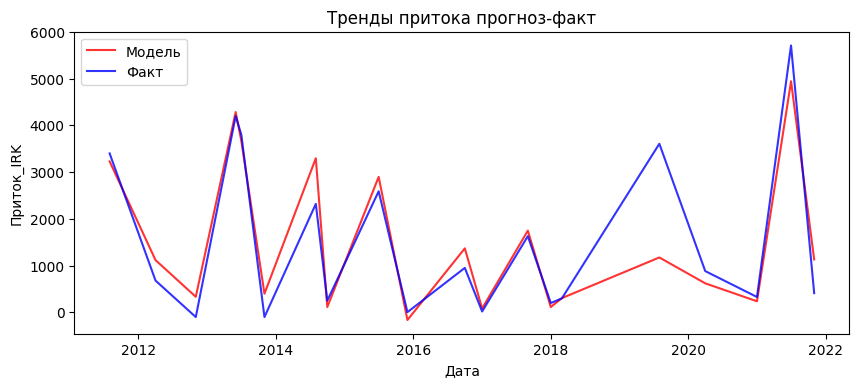

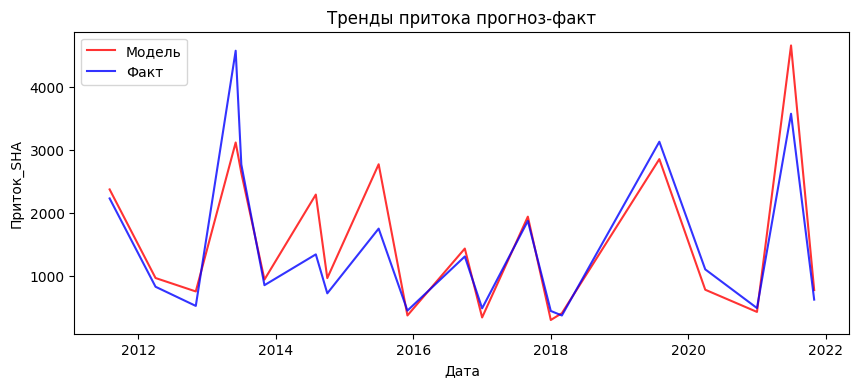

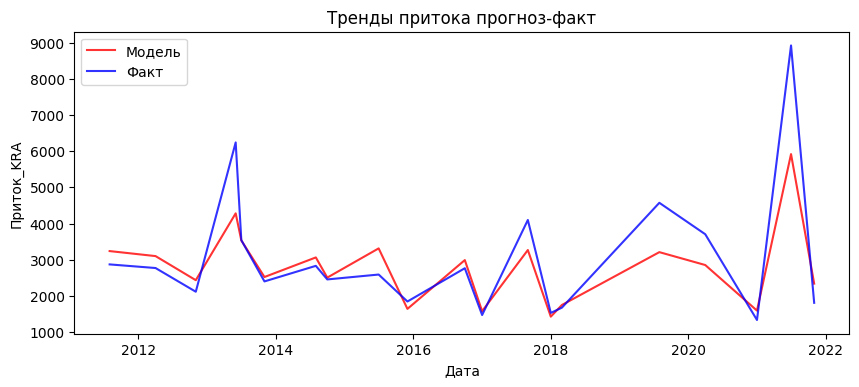

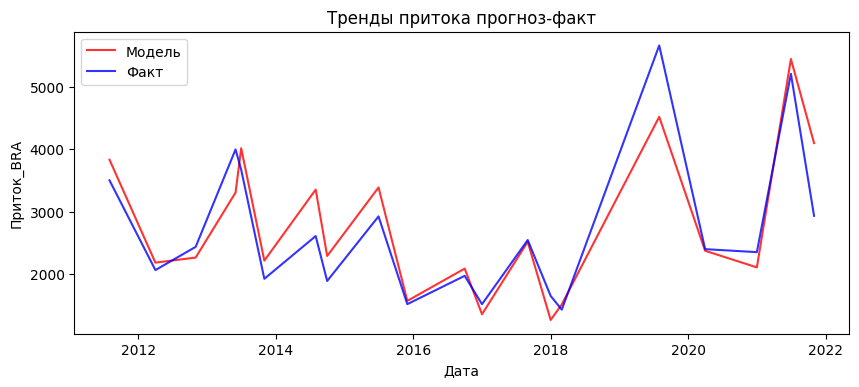

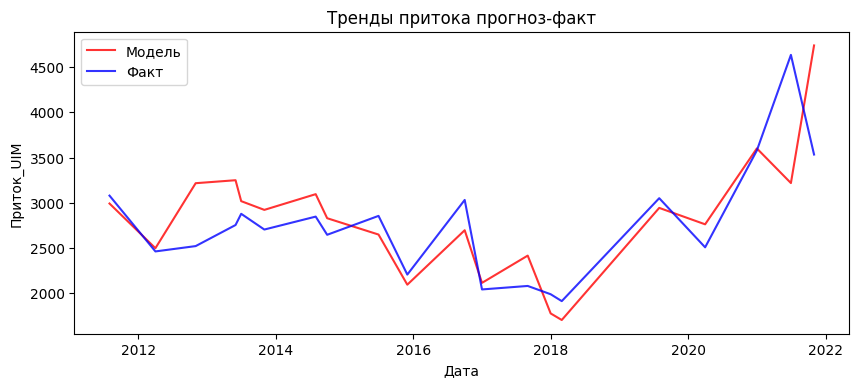

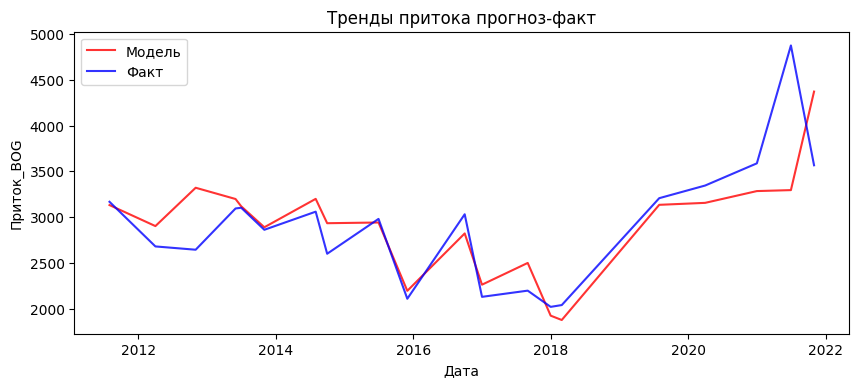

In [11]:
for col in GES_pritok:
    plt.subplots(figsize=(10,4), dpi=100);
    sns.lineplot(y=model_cat_pritok[col].predict(X_test_pritok), x=X_test_pritok.index, label='Модель', color='Red', alpha=0.8);
    sns.lineplot(y=y_test_pritok[col], x=X_test_pritok.index, label='Факт', color='Blue', alpha=0.8);
    plt.title('Тренды притока прогноз-факт');
    plt.savefig(f'../data/Результаты моделирования/Приток/{current_date} Модель для {col}.png', dpi=200);
    plt.show()

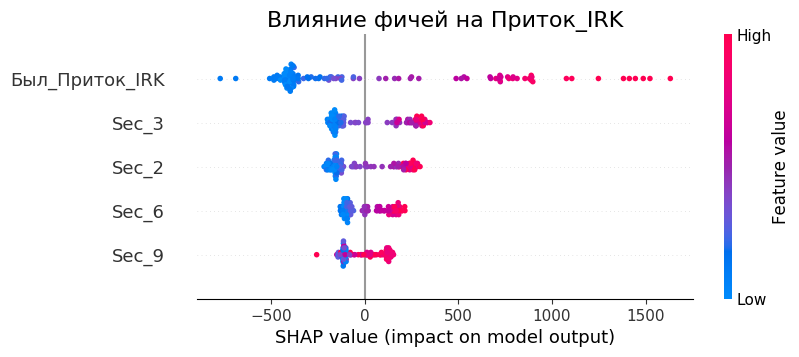

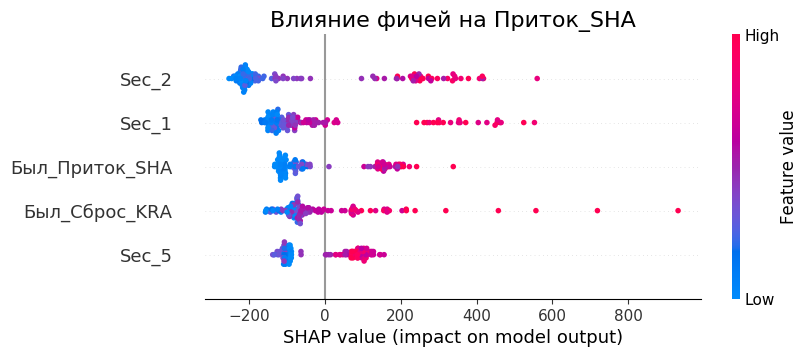

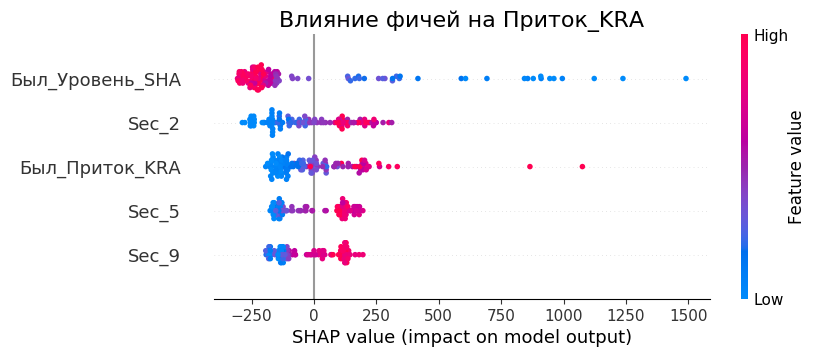

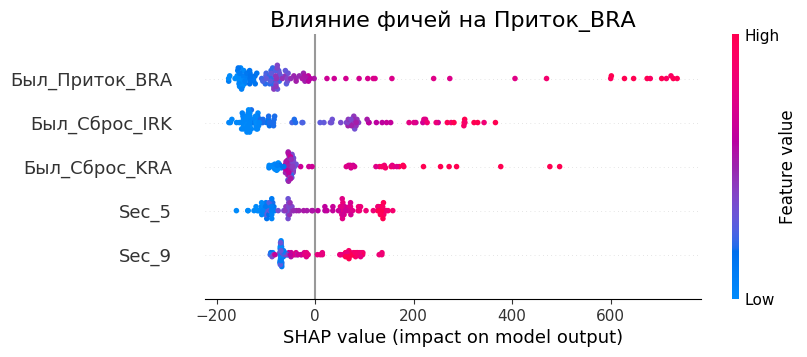

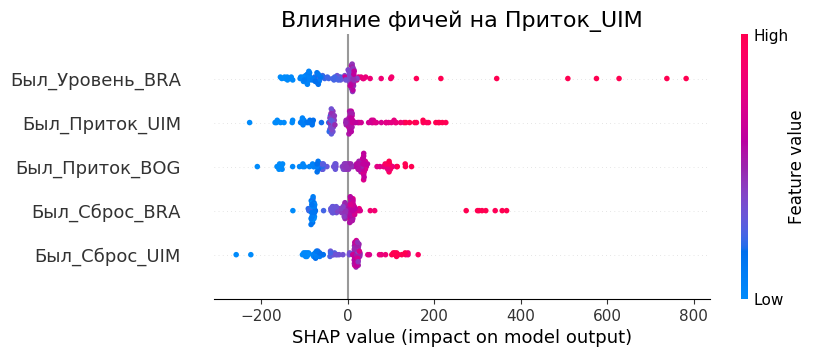

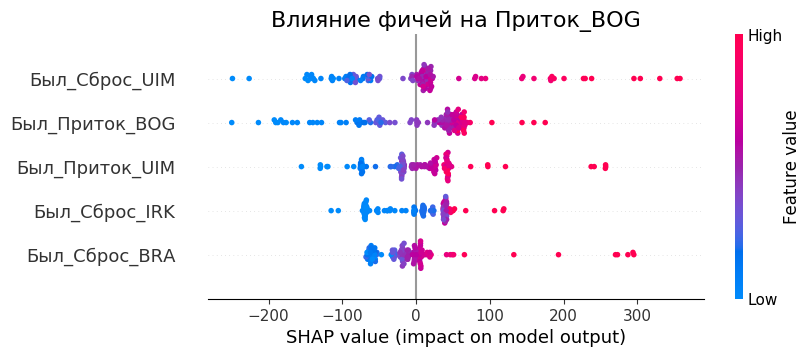

In [12]:
#Посмотрим на влияние фичей
for col in GES_pritok:
    fig, axes = plt.subplots(figsize=(6,4), dpi=100);
    shap.summary_plot(shap_values_pritok[col], X_train_pritok, show=False, max_display=5);
    plt.title(f'Влияние фичей на {col}', size=16);
    plt.savefig(f'../data/Результаты моделирования/Приток/{current_date} Влияние фичей на {col}.png', dpi=200);
    plt.show();

# Этап 3
Прогноз сброса

In [13]:
#Соберем данные
#Добавим дополнительные фичи и целевую переменную
df_sbros = pd.concat([target.shift(1).add_prefix('Был_'), 
                      target.loc[:, GES_pritok+GES_sbros]
                      ], axis=1).loc[ml_fact.index];

df_sbros.insert(0, 'month', df_sbros.index.month.astype(float));
df_sbros.insert(1, 'weekofyear', pd.Int64Index(df_sbros.index.isocalendar().week).astype(float));

df_sbros

month  weekofyear  Был_Приток_IRK  Был_Приток_SHA  Был_Приток_KRA  \
Дата                                                                            
2011-04-01    4.0        13.0      300.000000      360.000000     1715.000000   
2011-05-01    5.0        17.0      900.000000     1530.000000     3790.000000   
2011-06-01    6.0        22.0     3000.000000     2090.000000     4730.000000   
2011-07-01    7.0        26.0     4050.000000     3800.000000     4600.000000   
2011-08-01    8.0        31.0     3700.000000     2550.000000     3150.000000   
...           ...         ...             ...             ...             ...   
2021-12-01   12.0        48.0      412.000000      620.000000     1808.500000   
2022-01-01    1.0        52.0     -158.333333      515.161290     1547.391304   
2022-02-01    2.0         5.0      539.285714      457.741935     1499.032258   
2022-03-01    3.0         9.0      530.357143      418.928571     1385.714286   
2022-04-01    4.0        13.0      359.354839      408.709677     2205.483871   

            Был_Приток_BRA  Был_Приток_UIM  Был_Приток_BOG  Был_Сброс_IRK  \
Дата                                                                        
2011-04-01     1837.000000     3185.000000     3449.000000    1667.000000   
2011-05-01     2713.000000     3502.000000     3764.000000    1983.000000   
2011-06-01     2800.000000     3584.000000     3316.000000    1700.000000   
2011-07-01     3303.000000     3231.000000     3258.000000    1503.000000   
2011-08-01     3700.000000     2881.000000     3176.000000    1500.000000   
...                    ...             ...             ...            ...   
2021-12-01     2930.566667     3533.400000     3566.233333    2422.433333   
2022-01-01     2619.666667     5479.133333     3431.129032    2281.333333   
2022-02-01     2271.935484     3928.064516     3641.096774    2032.903226   
2022-03-01     1726.964286     3327.500000     3830.142857    1539.285714   
2022-04-01     2235.967742     3222.709677     3640.645161    2056.612903   

            Был_Сброс_SHA  ...   Приток_KRA   Приток_BRA   Приток_UIM  \
Дата                       ...                                          
2011-04-01    1386.000000  ...  3790.000000  2713.000000  3502.000000   
2011-05-01    2635.000000  ...  4730.000000  2800.000000  3584.000000   
2011-06-01    1428.000000  ...  4600.000000  3303.000000  3231.000000   
2011-07-01    1345.000000  ...  3150.000000  3700.000000  2881.000000   
2011-08-01    1238.000000  ...  2870.000000  3501.000000  3079.000000   
...                   ...  ...          ...          ...          ...   
2021-12-01    1275.700000  ...  1547.391304  2619.666667  5479.133333   
2022-01-01    1210.290323  ...  1499.032258  2271.935484  3928.064516   
2022-02-01    1209.677419  ...  1385.714286  1726.964286  3327.500000   
2022-03-01    1153.571429  ...  2205.483871  2235.967742  3222.709677   
2022-04-01    1457.129032  ...  2548.695652  3010.800000  3215.480000   

             Приток_BOG    Сброс_IRK    Сброс_SHA    Сброс_KRA    Сброс_BRA  \
Дата                                                                          
2011-04-01  3764.000000  1983.000000  2635.000000  2767.000000  2795.000000   
2011-05-01  3316.000000  1700.000000  1428.000000  3014.000000  3078.000000   
2011-06-01  3258.000000  1503.000000  1345.000000  2845.000000  2978.000000   
2011-07-01  3176.000000  1500.000000  1238.000000  2731.000000  2697.000000   
2011-08-01  3167.000000  1501.000000  1683.000000  2788.000000  2905.000000   
...                 ...          ...          ...          ...          ...   
2021-12-01  3431.129032  2281.333333  1210.290323  3581.304348  5479.133333   
2022-01-01  3641.096774  2032.903226  1209.677419  2416.129032  3928.064516   
2022-02-01  3830.142857  1539.285714  1153.571429  2311.428571  3327.500000   
2022-03-01  3640.645161  2056.612903  1457.129032  2314.838710  3222.709677   
2022-04-01  3569.000000  2436.400000  1415.960000  2223.91

In [14]:
X_train_sbros, X_test_sbros, y_train_sbros, y_test_sbros = train_test_split(df_sbros.drop(columns=GES_sbros),
                                                                            df_sbros.loc[:, GES_sbros],
                                                                            test_size=0.15,
                                                                            random_state=42);

display(X_train_sbros, X_test_sbros, y_train_sbros, y_test_sbros);

month  weekofyear  Был_Приток_IRK  Был_Приток_SHA  Был_Приток_KRA  \
Дата                                                                            
2014-04-01    4.0        14.0      600.000000      415.000000     1775.000000   
2012-08-01    8.0        31.0     4500.000000     1660.000000     2660.000000   
2012-10-01   10.0        40.0     2200.000000     1580.000000     2630.000000   
2012-02-01    2.0         5.0      100.000000      390.000000     1740.000000   
2016-09-01    9.0        35.0     3041.935484     3025.806452     3975.454545   
...           ...         ...             ...             ...             ...   
2017-03-01    3.0         9.0      275.185185      386.428571     1607.647059   
2020-02-01    2.0         5.0      120.000000      453.225806     1750.000000   
2012-06-01    6.0        22.0     2700.000000     2660.000000     4720.000000   
2018-12-01   12.0        48.0     2000.000000      661.333333     1906.000000   
2019-10-01   10.0        40.0     2333.333333     1925.000000     4092.857143   

            Был_Приток_BRA  Был_Приток_UIM  Был_Приток_BOG  Был_Сброс_IRK  \
Дата                                                                        
2014-04-01     2070.000000     3071.000000     3144.000000    1906.000000   
2012-08-01     4166.000000     3177.000000     3345.000000    2166.000000   
2012-10-01     3200.000000     3519.000000     3632.000000    1800.000000   
2012-02-01     1710.000000     2933.000000     2908.000000    1500.000000   
2016-09-01     4549.032258     2834.032258     2936.064516    1300.000000   
...                    ...             ...             ...            ...   
2017-03-01     1437.592593     1940.777778     2149.000000    1250.000000   
2020-02-01     1674.000000     2785.666667     2909.838710    1436.666667   
2012-06-01     2871.000000     3541.000000     3797.000000    1471.000000   
2018-12-01     2086.000000     2378.266667     2363.600000    1710.000000   
2019-10-01     3648.500000     3116.933333     3272.966667    2150.333333   

            Был_Сброс_SHA  ...  Был_Уровень_KRA  Был_Уровень_BRA  \
Дата                       ...                                     
2014-04-01    1379.000000  ...           234.41           396.93   
2012-08-01     758.000000  ...           233.05           397.30   
2012-10-01     778.000000  ...           232.01           397.59   
2012-02-01    1175.000000  ...           231.49           396.75   
2016-09-01    2408.580645  ...           240.83           397.54   
...                   ...  ...              ...              ...   
2017-03-01    1378.285714  ...           234.02           395.71   
2020-02-01    1432.258065  ...           235.47           398.55   
2012-06-01    1408.000000  ...           233.05           396.32   
2018-12-01    1327.700000  ...           239.28           396.40   
2019-10-01    2235.900000  ...           239.89           399.98   

            Был_Уровень_UIM  Был_Уровень_BOG   Приток_IRK   Приток_SHA  \
Дата                                                                     
2014-04-01           294.96           200.07  1730.000000  1000.000000   
2012-08-01           295.77           192.78  4200.000000  1570.000000   
2012-10-01           295.71           192.78   900.000000  1020.000000   
2012-02-01           295.84           192.78   290.000000   340.000000   
2016-09-01           295.71           207.54  2580.000000  1935.000000   
...                     ...              ...          ...          ...   
2017-03-01           295.45           207.24   298.709677   391.935484   
2020-02-01           295.89           207.63   307.931034   408.275862   
2012-06-01           295.68           192.78  4600.000000  2540.000000   
2018-12-01           295.66           207.64   796.296296   519.000000   
2019-10-01           295.83           207.77   796.774194  1352.258065   

             Приток_KRA   Приток_BRA   Приток_UIM   Приток_BOG  
Дата                                       

month  weekofyear  Был_Приток_IRK  Был_Приток_SHA  Был_Приток_KRA  \
Дата                                                                            
2015-07-01    7.0        27.0     3370.000000     3360.000000     4770.000000   
2017-01-01    1.0        52.0     -296.774194      543.870968     1613.440000   
2013-11-01   11.0        44.0     1100.000000     1740.000000     2915.000000   
2014-10-01   10.0        40.0      930.000000      780.000000     2200.000000   
2021-01-01    1.0        53.0      -90.322581      478.064516     1630.454545   
2017-09-01    9.0        35.0     2496.774194     2435.483871     3172.608696   
2021-11-01   11.0        44.0     2396.774194     1196.774194     2434.285714   
2015-12-01   12.0        49.0     -160.000000      515.000000     2085.000000   
2014-08-01    8.0        31.0     3150.000000     2250.000000     3040.000000   
2012-04-01    4.0        13.0      280.000000      335.000000     1700.000000   
2018-01-01    1.0         1.0     -393.548387      480.322581     1577.894737   
2013-06-01    6.0        22.0     3200.000000     3000.000000     6220.000000   
2020-04-01    4.0        14.0      310.000000      432.903226     1541.904762   
2019-08-01    8.0        31.0      350.000000     3539.285714     3453.478261   
2016-10-01   10.0        39.0     2580.000000     1935.000000     3058.636364   
2018-03-01    3.0         9.0      296.428571      323.571429     1534.210526   
2011-08-01    8.0        31.0     3700.000000     2550.000000     3150.000000   
2013-07-01    7.0        27.0     4200.000000     4580.000000     6240.000000   
2012-11-01   11.0        44.0      900.000000     1020.000000     2670.000000   
2021-07-01    7.0        26.0     4316.666667     6993.333333    11151.904762   

            Был_Приток_BRA  Был_Приток_UIM  Был_Приток_BOG  Был_Сброс_IRK  \
Дата                                                                        
2015-07-01     2965.000000     2661.000000     2924.000000    1314.000000   
2017-01-01     1557.419355     2149.258065     2236.258065    1300.000000   
2013-11-01     2390.000000     2931.000000     2946.000000    1500.000000   
2014-10-01     2374.000000     3055.000000     2896.000000    1419.000000   
2021-01-01     2743.354839     3512.741935     3486.225806    2462.064516   
2017-09-01     2719.354839     2378.612903     2656.580645    1300.000000   
2021-11-01     4464.161290     3919.967742     4170.290323    3448.225806   
2015-12-01     1607.000000     2073.000000     2106.000000    1300.000000   
2014-08-01     3118.000000     3207.000000     3035.000000    1512.000000   
2012-04-01     1631.000000     2277.000000     2577.000000    1461.000000   
2018-01-01     1545.483871     1991.483871     2031.290323    1300.000000   
2013-06-01     2955.000000     3523.000000     4654.000000    1455.000000   
2020-04-01     2043.166667     2762.433333     3289.806452    1850.000000   
2019-08-01     5371.870968     2977.774194     3085.500000    2119.870968   
2016-10-01     2650.200000     2786.700000     2965.833333    1318.166667   
2018-03-01     1427.142857     1958.714286     2025.285714    1250.000000   
2011-08-01     3700.000000     2881.000000     3176.000000    1500.000000   
2013-07-01     3997.000000     2754.000000     3094.000000    1597.000000   
2012-11-01     2641.000000     3097.000000     3603.000000    1871.000000   
2021-07-01     6046.566667     2852.966667     3038.766667    2275.500000   

            Был_Сброс_SHA  ...  Был_Уровень_KRA  Был_Уровень_BRA  \
Дата                       ...                                     
2015-07-01    1496.000000  ...           239.25           396.25   
2017-01-01    1308.225806  ...           238.76           396.31   
2013-11-01    2134.000000  ...           241.97           398.92   
2014-10-01     892.000000  ...           236.70           397.28   
2021-01-01    1297.354839  ...           236.65           399.90   
2017-09-01    1029.677419  ...           237.89           

Сброс_IRK    Сброс_SHA    Сброс_KRA    Сброс_BRA    Сброс_UIM  \
Дата                                                                          
2014-04-01  2223.000000  1559.000000  3663.000000  2149.000000  2874.000000   
2012-08-01  2302.000000   783.000000  2197.000000  3260.000000  3394.000000   
2012-10-01  1871.000000  1287.000000  2063.000000  2917.000000  3490.000000   
2012-02-01  1500.000000  1402.000000  2416.000000  2493.000000  2801.000000   
2016-09-01  1318.166667  2048.966667  3152.727273  2786.700000  2842.636364   
...                 ...          ...          ...          ...          ...   
2017-03-01  1256.451613  1443.290323  2954.285714  2067.000000  2269.935484   
2020-02-01  1310.344828  1443.758621  2819.473684  3038.413793  3322.379310   
2012-06-01  1510.000000  1056.000000  2515.000000  2872.000000  2965.000000   
2018-12-01  2149.464286  1373.322581  3246.842105  2381.428571  2408.857143   
2019-10-01  1840.290323  1583.935484  3411.739130  2993.419355  3119.483871   

              Сброс_BOG  
Дата                     
2014-04-01  1587.000000  
2012-08-01  1531.000000  
2012-10-01  1531.000000  
2012-02-01  1531.000000  
2016-09-01  2987.500000  
...                 ...  
2017-03-01  2366.612903  
2020-02-01  3497.551724  
2012-06-01  1531.000000  
2018-12-01  2474.741935  
2019-10-01  3097.870968  

[113 rows x 6 columns]

Сброс_IRK    Сброс_SHA    Сброс_KRA    Сброс_BRA    Сброс_UIM  \
Дата                                                                          
2015-07-01  1300.000000   931.000000  2958.000000  2648.000000  2762.000000   
2017-01-01  1300.000000  1229.709677  2601.250000  2041.677419  2097.935484   
2013-11-01  1500.000000  1499.000000  2956.000000  2575.000000  2807.000000   
2014-10-01  1306.000000   897.000000  2547.000000  2519.000000  2547.000000   
2021-01-01  2179.645161  1065.806452  2620.666667  3578.161290  3584.419355   
2017-09-01  1308.166667  1862.566667  2992.000000  2080.266667  2070.366667   
2021-11-01  2422.433333  1275.700000  3688.000000  3533.400000  3527.200000   
2015-12-01  1300.000000  1247.000000  2061.000000  2086.000000  2078.000000   
2014-08-01  1500.000000  1067.000000  3084.000000  2677.000000  3007.000000   
2012-04-01  1400.000000  1444.000000  2238.000000  2228.000000  2585.000000   
2018-01-01  1435.161290  1215.064516  2587.647059  1988.580645  2059.838710   
2013-06-01  1597.000000  2123.000000  2803.000000  2290.000000  2683.000000   
2020-04-01  1630.000000  1481.500000  2940.909091  2507.533333  2907.933333   
2019-08-01  2310.677419  2558.290323  2861.818182  3050.548387  3131.838710   
2016-10-01  1300.000000  1928.766667  3133.750000  3031.225806  2000.000000   
2018-03-01  1250.000000  1411.967742  2904.000000  1912.483871  2016.709677   
2011-08-01  1501.000000  1683.000000  2788.000000  2905.000000  2988.000000   
2013-07-01  1571.000000  2141.000000  3519.000000  2645.000000  2886.000000   
2012-11-01  2083.000000  1056.000000  2050.000000  2377.000000  2450.000000   
2021-07-01  3018.709677  2957.548387  5280.000000  4635.258065  4716.612903   

              Сброс_BOG  
Дата                     
2015-07-01  3067.000000  
2017-01-01  2310.129032  
2013-11-01  1531.000000  
2014-10-01  2465.000000  
2021-01-01  3488.225806  
2017-09-01  2071.700000  
2021-11-01  3631.233333  
2015-12-01  2029.000000  
2014-08-01  3087.000000  
2012-04-01  1531.000000  
2018-01-01  2091.225806  
2013-06-01  1531.000000  
2020-04-01  3126.400000  
2019-08-01  3138.516129  
2016-10-01  2832.354839  
2018-03-01  2078.903226  
2011-08-01  1531.000000  
2013-07-01  1531.000000  
2012-11-01  1531.000000  
2021-07-01  4866.064516

In [15]:
#Проведем нормализацию данных
#Она нужна, чтобы снизить влияние фичей с большими показателями
scaler_sbros = StandardScaler();
scaler_sbros.fit(X_train_sbros);
X_train_sbros = pd.DataFrame(data=scaler_sbros.transform(X_train_sbros),
                             index=X_train_sbros.index,
                             columns=X_train_sbros.columns);

#Сохраним модель стандартизации данных
joblib.dump(scaler_sbros,
           f'../data/Параметры модели/StandardScaler fit/{current_date} Сброс Стандартизация данных.joblib');

X_test_sbros = pd.DataFrame(data=scaler_sbros.transform(X_test_sbros),
                            index=X_test_sbros.index,
                            columns=X_test_sbros.columns);

display(X_train_sbros, X_test_sbros);

month  weekofyear  Был_Приток_IRK  Был_Приток_SHA  \
Дата                                                               
2014-04-01 -0.698236   -0.750666       -0.533665       -0.882277   
2012-08-01  0.466349    0.377682        1.885741        0.209487   
2012-10-01  1.048642    0.975043        0.458912        0.139334   
2012-02-01 -1.280528   -1.348027       -0.843845       -0.904200   
2016-09-01  0.757496    0.643176        0.981216        1.407190   
...              ...         ...             ...             ...   
2017-03-01 -0.989382   -1.082533       -0.735167       -0.907332   
2020-02-01 -1.280528   -1.348027       -0.831438       -0.848756   
2012-06-01 -0.115943   -0.219678        0.769092        1.086407   
2018-12-01  1.630934    1.506030        0.334840       -0.666263   
2019-10-01  1.048642    0.975043        0.541627        0.441871   

            Был_Приток_KRA  Был_Приток_BRA  Был_Приток_UIM  Был_Приток_BOG  \
Дата                                                                         
2014-04-01       -0.800950       -0.510699        0.418841        0.308463   
2012-08-01       -0.208162        1.502867        0.575691        0.628118   
2012-10-01       -0.228256        0.574859        1.081752        1.084542   
2012-02-01       -0.824394       -0.856540        0.214641       -0.066854   
2016-09-01        0.672953        1.870835        0.068197       -0.022222   
...                    ...             ...             ...             ...   
2017-03-01       -0.913046       -1.118234       -1.253561       -1.273911   
2020-02-01       -0.817696       -0.891124       -0.003370       -0.063930   
2012-06-01        1.171662        0.258798        1.114305        1.346945   
2018-12-01       -0.713204       -0.495328       -0.606204       -0.932627   
2019-10-01        0.751591        1.005720        0.486809        0.513562   

            Был_Сброс_IRK  Был_Сброс_SHA  ...  Был_Уровень_KRA  \
Дата                                      ...                    
2014-04-01       0.530031      -0.239819  ...        -0.362117   
2012-08-01       1.112369      -1.544936  ...        -0.749572   
2012-10-01       0.292616      -1.502903  ...        -1.045862   
2012-02-01      -0.379312      -0.668553  ...        -1.194006   
2016-09-01      -0.827265       1.923986  ...         1.466899   
...                   ...            ...  ...              ...   
2017-03-01      -0.939253      -0.241320  ...        -0.473226   
2020-02-01      -0.521164      -0.127890  ...        -0.060130   
2012-06-01      -0.444265      -0.178871  ...        -0.749572   
2018-12-01       0.091038      -0.347633  ...         1.025314   
2019-10-01       1.077280       1.561074  ...         1.199099   

            Был_Уровень_BRA  Был_Уровень_UIM  Был_Уровень_BOG  Приток_IRK  \
Дата                                                                        
2014-04-01        -0.221780        -1.179586        -0.512570    0.156693   
2012-08-01         0.005713         0.785961        -1.666577    1.712409   
2012-10-01         0.184019         0.640365        -1.666577   -0.366077   
2012-02-01        -0.332453         0.955823        -1.666577   -0.750282   
2016-09-01         0.153276         0.640365         0.669931    0.692061   
...                     ...              ...              ...         ...   
2017-03-01        -0.971893         0.009449         0.622441   -0.744797   
2020-02-01         0.774272         1.077153         0.684178   -0.738988   
2012-06-01        -0.596837         0.567567        -1.666577    1.964347   
2018-12-01        -0.547649         0.519035         0.685761   -0.431394   
2019-10-01         1.653503         0.931557         0.706340   -0.431093   

            Приток_SHA  Приток_KRA  Приток_BRA  Приток_UIM  Приток_BOG  
Дата                                                                    
2014-04-01   -0.399186    0.330641    0.309937   -0.085036    0.238654  
2012-08-01    0.052173   -0.298382 

month  weekofyear  Был_Приток_IRK  Был_Приток_SHA  \
Дата                                                               
2015-07-01  0.175203    0.112189        1.184734        1.700250   
2017-01-01 -1.571674    1.771524       -1.089988       -0.769268   
2013-11-01  1.339788    1.240537       -0.223484        0.279641   
2014-10-01  1.048642    0.975043       -0.328946       -0.562202   
2021-01-01 -1.571674    1.837898       -0.961913       -0.826975   
2017-09-01  0.757496    0.643176        0.643019        0.889524   
2021-11-01  1.339788    1.240537        0.580983       -0.196724   
2015-12-01  1.630934    1.572404       -1.005138       -0.794585   
2014-08-01  0.466349    0.377682        1.048255        0.726870   
2012-04-01 -0.698236   -0.817039       -0.732180       -0.952431   
2018-01-01 -1.571674   -1.613520       -1.150023       -0.824994   
2013-06-01 -0.115943   -0.219678        1.079273        1.384559   
2020-04-01 -0.698236   -0.750666       -0.713569       -0.866577   
2019-08-01  0.466349    0.377682       -0.688755        1.857469   
2016-10-01  1.048642    0.908670        0.694649        0.450640   
2018-03-01 -0.989382   -1.082533       -0.721988       -0.962453   
2011-08-01  0.466349    0.377682        1.389453        0.989946   
2013-07-01  0.175203    0.112189        1.699633        2.770092   
2012-11-01  1.339788    1.240537       -0.347556       -0.351741   
2021-07-01  0.175203    0.045815        1.772008        4.886391   

            Был_Приток_KRA  Был_Приток_BRA  Был_Приток_UIM  Был_Приток_BOG  \
Дата                                                                         
2015-07-01        1.205153        0.349101       -0.187840       -0.041409   
2017-01-01       -0.909166       -1.003120       -0.945070       -1.135142   
2013-11-01       -0.037358       -0.203284        0.211682       -0.006422   
2014-10-01       -0.516278       -0.218655        0.395166       -0.085938   
2021-01-01       -0.897770        0.136173        1.072491        0.852713   
2017-09-01        0.135192        0.113117       -0.605692       -0.466692   
2021-11-01       -0.359349        1.789302        1.675068        1.940598   
2015-12-01       -0.593307       -0.955489       -1.057910       -1.342295   
2014-08-01        0.046369        0.496084        0.620082        0.135117   
2012-04-01       -0.851187       -0.932433       -0.756049       -0.593252   
2018-01-01       -0.932975       -1.014586       -1.178531       -1.461108   
2013-06-01        2.176389        0.339495        1.087670        2.709854   
2020-04-01       -0.957082       -0.536477       -0.037748        0.540343   
2019-08-01        0.323324        2.661312        0.280894        0.215429   
2016-10-01        0.058852        0.046682       -0.001841        0.025120   
2018-03-01       -0.962235       -1.128273       -1.227020       -1.470657   
2011-08-01        0.120049        1.055194        0.137696        0.359353   
2013-07-01        2.189785        1.340513       -0.050227        0.228947   
2012-11-01       -0.201464        0.037844        0.457314        1.038422   
2021-07-01        5.479866        3.309472        0.096215        0.141108   

            Был_Сброс_IRK  Был_Сброс_SHA  ...  Был_Уровень_KRA  \
Дата                                      ...                    
2015-07-01      -0.795908       0.006073  ...         1.016767   
2017-01-01      -0.827265      -0.388560  ...         0.877169   
2013-11-01      -0.379312       1.346917  ...         1.791677   
2014-10-01      -0.560733      -1.263316  ...         0.290289   
2021-01-01       1.775483      -0.411407  ...         0.276044   
2017-09-01      -0.827265      -0.973968  ...         0.629312   
2021-11-01       3.984250       0.339555  ...         1.321603   
2015-12-01      -0.827265      -0.496219  ...        -0.188332   
2014-08-01      -0.352435       0.245659  ...         1.110782   
2012-04-01      -0.466663      -0.178871  ...        -1.817923   
2018-01-0

In [16]:
%%time
model_cat_sbros = {};
sbros_score = {}; #Для записи метрик
y_predicted_sbros = {}; #Прогноз притока по каждой ГЭС
shap_values_sbros = {}; #Влияние фичей

for col in GES_sbros:
    model_cat_sbros[col] = CatBoostRegressor(depth=2,
                                             iterations=1600,
                                             learning_rate=0.03,
                                             eval_metric='RMSE');
    model_cat_sbros[col].fit(X_train_sbros,
                             y_train_sbros[col]);

    y_predicted_sbros[col] = model_cat_sbros[col].predict(X_test_sbros);
    sbros_score[col] = score_my(y_test_sbros[col], y_predicted_sbros[col]);
    
    #Сохраним коэффициенты модели
    model_cat_sbros[col].save_model(f'../data/Параметры модели/coef CatBoost сброс/{current_date} Модель для {col}.cbm'); #Сохраним модель
    
    #Влияние фичей
    explainer_sbros = shap.TreeExplainer(model_cat_sbros[col]);
    shap_values_sbros[col] = explainer_sbros.shap_values(Pool(X_train_sbros, y_train_sbros[col]));

0:	learn: 1696.8936937	total: 859us	remaining: 1.37s
1:	learn: 1653.2555799	total: 1.71ms	remaining: 1.37s
2:	learn: 1610.9881776	total: 2.11ms	remaining: 1.12s
3:	learn: 1570.3953965	total: 2.46ms	remaining: 981ms
4:	learn: 1530.2585516	total: 2.8ms	remaining: 893ms
5:	learn: 1491.2404321	total: 3.44ms	remaining: 913ms
6:	learn: 1452.8072559	total: 4.04ms	remaining: 919ms
7:	learn: 1416.1350649	total: 4.64ms	remaining: 923ms
8:	learn: 1380.3795094	total: 5.49ms	remaining: 970ms
9:	learn: 1345.1736883	total: 6.26ms	remaining: 995ms
10:	learn: 1311.4270780	total: 6.99ms	remaining: 1.01s
11:	learn: 1278.7244269	total: 7.56ms	remaining: 1s
12:	learn: 1246.6785369	total: 7.96ms	remaining: 972ms
13:	learn: 1215.4931532	total: 8.65ms	remaining: 980ms
14:	learn: 1186.5696943	total: 9.24ms	remaining: 977ms
15:	learn: 1156.7420136	total: 9.6ms	remaining: 950ms
16:	learn: 1128.8905584	total: 9.96ms	remaining: 928ms
17:	learn: 1102.5715825	total: 10.3ms	remaining: 907ms
18:	learn: 1076.4020154	to

In [17]:
#Результаты удовлетворительные
sbros_score

{'Сброс_IRK': 'RMSE: 12.34%, 204.8566; MAE: 9.24%, 153.3958',
 'Сброс_SHA': 'RMSE: 20.80%, 323.1662; MAE: 15.49%, 240.7190',
 'Сброс_KRA': 'RMSE: 9.00%, 263.7809; MAE: 7.02%, 205.6363',
 'Сброс_BRA': 'RMSE: 8.05%, 214.5851; MAE: 5.38%, 143.2799',
 'Сброс_UIM': 'RMSE: 12.58%, 345.4932; MAE: 7.44%, 204.1807',
 'Сброс_BOG': 'RMSE: 12.60%, 311.6934; MAE: 7.74%, 191.4506'}

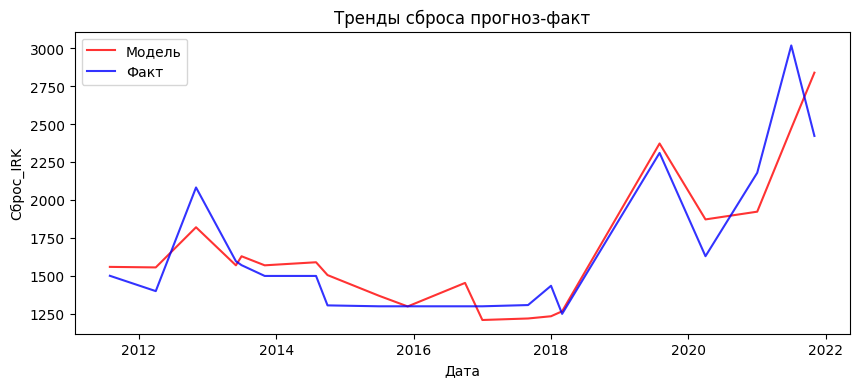

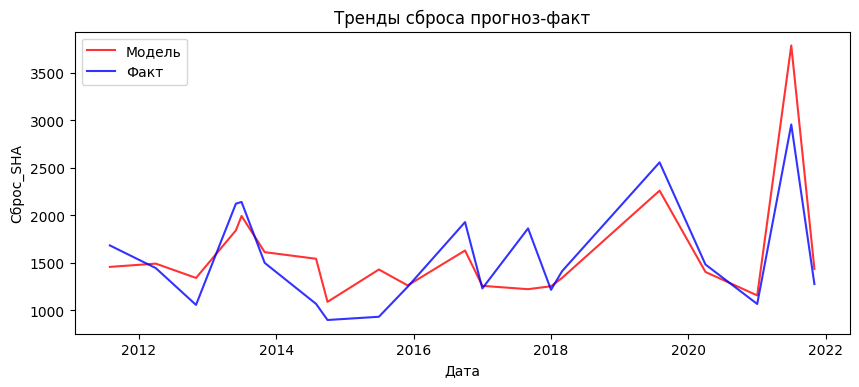

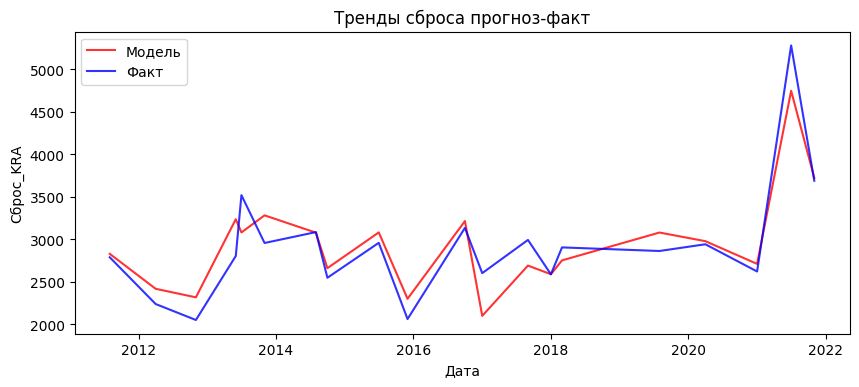

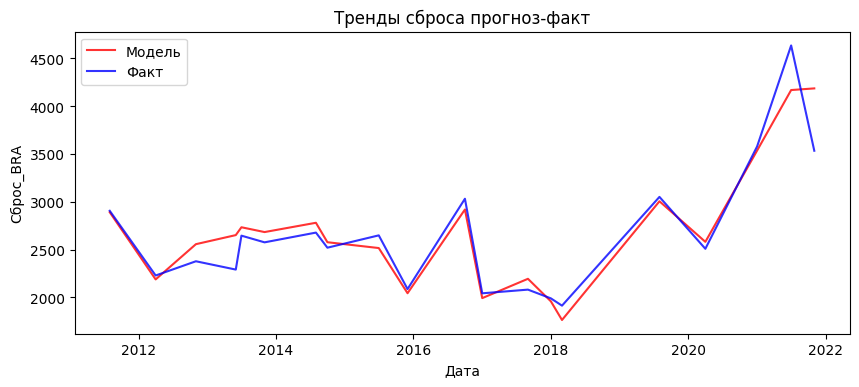

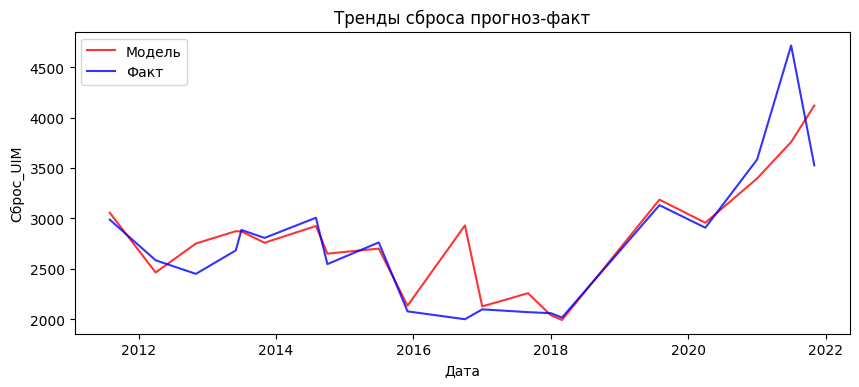

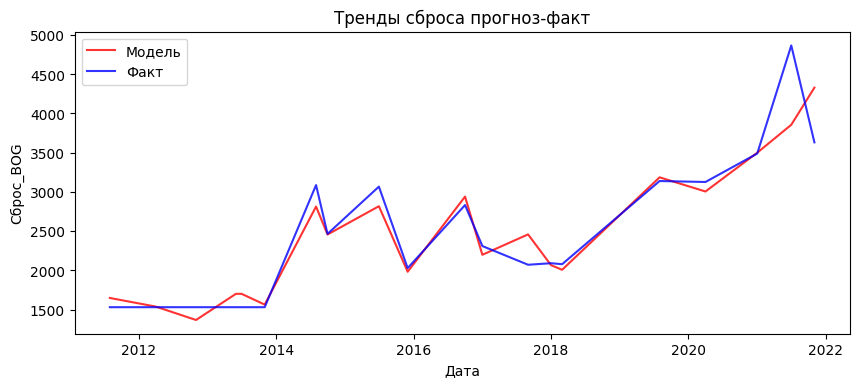

In [18]:
for col in GES_sbros:
    plt.subplots(figsize=(10,4), dpi=100);
    sns.lineplot(y=model_cat_sbros[col].predict(X_test_sbros), x=X_test_sbros.index, label='Модель', color='Red', alpha=0.8);
    sns.lineplot(y=y_test_sbros[col], x=X_test_sbros.index, label='Факт', color='Blue', alpha=0.8);
    plt.title('Тренды сброса прогноз-факт');
    plt.savefig(f'../data/Результаты моделирования/Сброс/{current_date} Модель для {col}.png', dpi=200);
    plt.show()

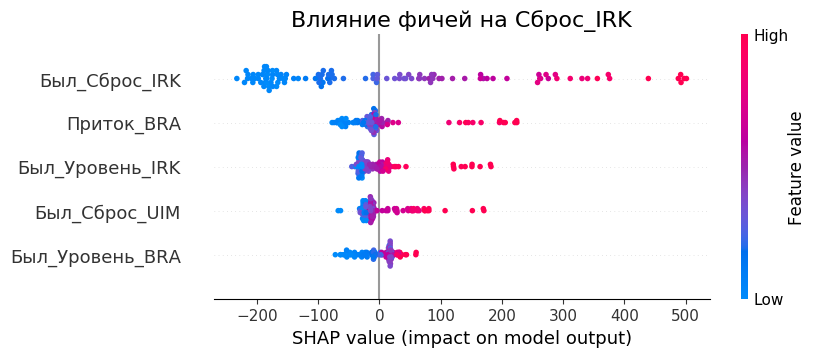

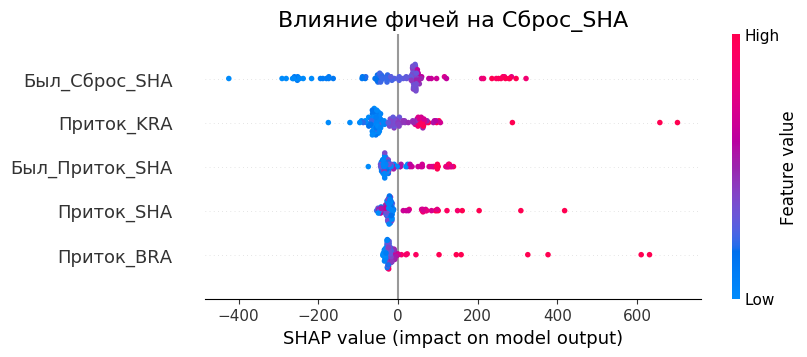

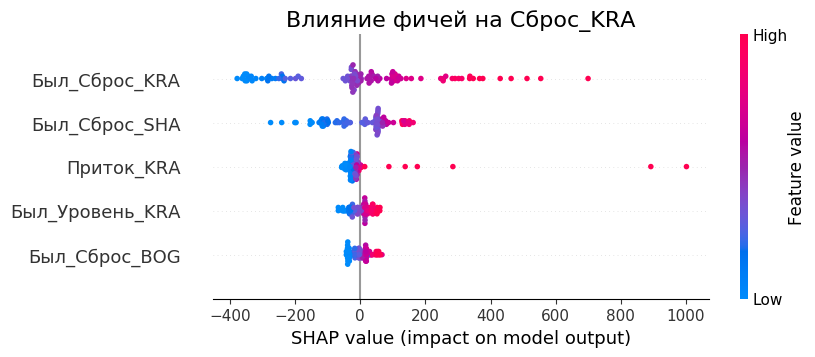

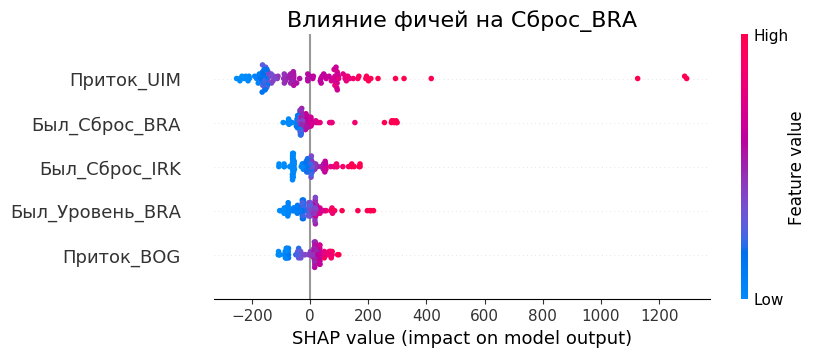

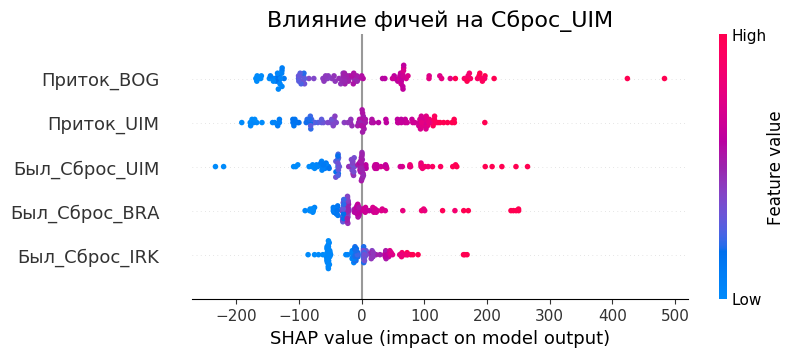

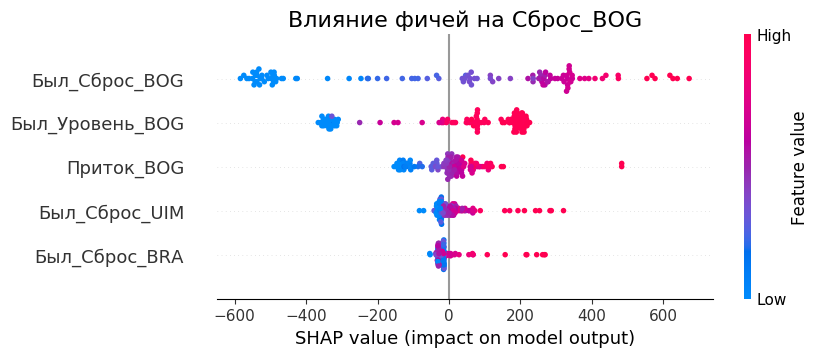

In [19]:
#Посмотрим на влияние фичей
for col in GES_sbros:
    fig, axes = plt.subplots(figsize=(6,4), dpi=100);
    shap.summary_plot(shap_values_sbros[col], X_train_sbros, show=False, max_display=5);
    plt.title(f'Влияние фичей на {col}', size=16);
    plt.savefig(f'../data/Результаты моделирования/Сброс/{current_date} Влияние фичей на {col}.png', dpi=200);
    plt.show();

# Этап 4
Прогноз уровень

In [20]:
#Соберем данные
#Добавим дополнительные фичи и целевую переменную
df_uroven = pd.concat([target.shift(1).add_prefix('Был_'), 
                       target.loc[:, GES_pritok+GES_sbros+GES_uroven]
                      ], axis=1).loc[ml_fact.index];

df_uroven.insert(0, 'month', df_uroven.index.month.astype(float));
df_uroven.insert(1, 'weekofyear', pd.Int64Index(df_uroven.index.isocalendar().week).astype(float));

df_uroven

month  weekofyear  Был_Приток_IRK  Был_Приток_SHA  Был_Приток_KRA  \
Дата                                                                            
2011-04-01    4.0        13.0      300.000000      360.000000     1715.000000   
2011-05-01    5.0        17.0      900.000000     1530.000000     3790.000000   
2011-06-01    6.0        22.0     3000.000000     2090.000000     4730.000000   
2011-07-01    7.0        26.0     4050.000000     3800.000000     4600.000000   
2011-08-01    8.0        31.0     3700.000000     2550.000000     3150.000000   
...           ...         ...             ...             ...             ...   
2021-12-01   12.0        48.0      412.000000      620.000000     1808.500000   
2022-01-01    1.0        52.0     -158.333333      515.161290     1547.391304   
2022-02-01    2.0         5.0      539.285714      457.741935     1499.032258   
2022-03-01    3.0         9.0      530.357143      418.928571     1385.714286   
2022-04-01    4.0        13.0      359.354839      408.709677     2205.483871   

            Был_Приток_BRA  Был_Приток_UIM  Был_Приток_BOG  Был_Сброс_IRK  \
Дата                                                                        
2011-04-01     1837.000000     3185.000000     3449.000000    1667.000000   
2011-05-01     2713.000000     3502.000000     3764.000000    1983.000000   
2011-06-01     2800.000000     3584.000000     3316.000000    1700.000000   
2011-07-01     3303.000000     3231.000000     3258.000000    1503.000000   
2011-08-01     3700.000000     2881.000000     3176.000000    1500.000000   
...                    ...             ...             ...            ...   
2021-12-01     2930.566667     3533.400000     3566.233333    2422.433333   
2022-01-01     2619.666667     5479.133333     3431.129032    2281.333333   
2022-02-01     2271.935484     3928.064516     3641.096774    2032.903226   
2022-03-01     1726.964286     3327.500000     3830.142857    1539.285714   
2022-04-01     2235.967742     3222.709677     3640.645161    2056.612903   

            Был_Сброс_SHA  ...    Сброс_KRA    Сброс_BRA    Сброс_UIM  \
Дата                       ...                                          
2011-04-01    1386.000000  ...  2767.000000  2795.000000  3320.000000   
2011-05-01    2635.000000  ...  3014.000000  3078.000000  2981.000000   
2011-06-01    1428.000000  ...  2845.000000  2978.000000  3035.000000   
2011-07-01    1345.000000  ...  2731.000000  2697.000000  2990.000000   
2011-08-01    1238.000000  ...  2788.000000  2905.000000  2988.000000   
...                   ...  ...          ...          ...          ...   
2021-12-01    1275.700000  ...  3581.304348  5479.133333  3391.966667   
2022-01-01    1210.290323  ...  2416.129032  3928.064516  3714.516129   
2022-02-01    1209.677419  ...  2311.428571  3327.500000  3792.500000   
2022-03-01    1153.571429  ...  2314.838710  3222.709677  3528.548387   
2022-04-01    1457.129032  ...  2223.913043  3215.480000  3543.400000   

              Сброс_BOG  Уровень_IRK  Уровень_SHA  Уровень_KRA  Уровень_BRA  \
Дата                                                                          
2011-04-01  1531.000000       456.10       501.25       233.86       397.70   
2011-05-01  1531.000000       456.19       508.55       236.15       397.69   
2011-06-01  1531.000000       456.40       527.19       238.14       397.90   
2011-07-01  1531.000000       456.63       534.28       238.19       398.35   
2011-08-01  1531.000000       456.76       536.79       238.32       398.69   
...                 ...          ...          ...          ...          ...   
2021-12-01  3702.548387       456.80       527.55       234.66       401.37   
2022-01-01  3538.709677       456.67       522.81       233.07       400.38   
2022-02-01  3980.357143       456.59       517.20       231.62       399.55   
2022-03-01  3834.838710       456.49       508.39       230.83       399.17   
2022-04-01  3686.920000       456.38       500.27       23

In [21]:
X_train_uroven, X_test_uroven, y_train_uroven, y_test_uroven = train_test_split(df_uroven.drop(columns=GES_uroven),
                                                                                df_uroven.loc[:, GES_uroven],
                                                                                test_size=0.15,
                                                                                random_state=42);

display(X_train_uroven, X_test_uroven, y_train_uroven, y_test_uroven);

month  weekofyear  Был_Приток_IRK  Был_Приток_SHA  Был_Приток_KRA  \
Дата                                                                            
2014-04-01    4.0        14.0      600.000000      415.000000     1775.000000   
2012-08-01    8.0        31.0     4500.000000     1660.000000     2660.000000   
2012-10-01   10.0        40.0     2200.000000     1580.000000     2630.000000   
2012-02-01    2.0         5.0      100.000000      390.000000     1740.000000   
2016-09-01    9.0        35.0     3041.935484     3025.806452     3975.454545   
...           ...         ...             ...             ...             ...   
2017-03-01    3.0         9.0      275.185185      386.428571     1607.647059   
2020-02-01    2.0         5.0      120.000000      453.225806     1750.000000   
2012-06-01    6.0        22.0     2700.000000     2660.000000     4720.000000   
2018-12-01   12.0        48.0     2000.000000      661.333333     1906.000000   
2019-10-01   10.0        40.0     2333.333333     1925.000000     4092.857143   

            Был_Приток_BRA  Был_Приток_UIM  Был_Приток_BOG  Был_Сброс_IRK  \
Дата                                                                        
2014-04-01     2070.000000     3071.000000     3144.000000    1906.000000   
2012-08-01     4166.000000     3177.000000     3345.000000    2166.000000   
2012-10-01     3200.000000     3519.000000     3632.000000    1800.000000   
2012-02-01     1710.000000     2933.000000     2908.000000    1500.000000   
2016-09-01     4549.032258     2834.032258     2936.064516    1300.000000   
...                    ...             ...             ...            ...   
2017-03-01     1437.592593     1940.777778     2149.000000    1250.000000   
2020-02-01     1674.000000     2785.666667     2909.838710    1436.666667   
2012-06-01     2871.000000     3541.000000     3797.000000    1471.000000   
2018-12-01     2086.000000     2378.266667     2363.600000    1710.000000   
2019-10-01     3648.500000     3116.933333     3272.966667    2150.333333   

            Был_Сброс_SHA  ...   Приток_KRA   Приток_BRA   Приток_UIM  \
Дата                       ...                                          
2014-04-01    1379.000000  ...  3550.000000  2975.000000  2736.000000   
2012-08-01     758.000000  ...  2540.000000  4002.000000  3487.000000   
2012-10-01     778.000000  ...  2670.000000  2641.000000  3097.000000   
2012-02-01    1175.000000  ...  1705.000000  1670.000000  2646.000000   
2016-09-01    2408.580645  ...  3058.636364  2650.200000  2786.700000   
...                   ...  ...          ...          ...          ...   
2017-03-01    1378.285714  ...  1632.857143  1450.806452  2067.000000   
2020-02-01    1432.258065  ...  1697.894737  1498.793103  3038.413793   
2012-06-01    1408.000000  ...  3670.000000  3610.000000  3160.000000   
2018-12-01    1327.700000  ...  1703.684211  2422.714286  2381.428571   
2019-10-01    2235.900000  ...  3634.782609  2853.419355  2993.419355   

             Приток_BOG    Сброс_IRK    Сброс_SHA    Сброс_KRA    Сброс_BRA  \
Дата                                                                          
2014-04-01  3116.000000  2223.000000  1559.000000  3663.000000  2149.000000   
2012-08-01  3589.000000  2302.000000   783.000000  2197.000000  3260.000000   
2012-10-01  3603.000000  1871.000000  1287.000000  2063.000000  2917.000000   
2012-02-01  2851.000000  1500.000000  1402.000000  2416.000000  2493.000000   
2016-09-01  2965.833333  1318.166667  2048.966667  3152.727273  2786.700000   
...                 ...          ...          ...          ...          ...   
2017-03-01  2268.354839  1256.451613  1443.290323  2954.285714  2067.000000   
2020-02-01  3319.689655  1310.344828  1443.758621  2819.473684  3038.413793   
2012-06-01  3205.000000  1510.000000  1056.000000  2515.000000  2872.000000   
2018-12-01  2426.400000  2149.464286  1373.322581  3246.842105  2381.428571   
2019-10-01  3239.419355  1840.290323  1583.935484  3411.73

month  weekofyear  Был_Приток_IRK  Был_Приток_SHA  Был_Приток_KRA  \
Дата                                                                            
2015-07-01    7.0        27.0     3370.000000     3360.000000     4770.000000   
2017-01-01    1.0        52.0     -296.774194      543.870968     1613.440000   
2013-11-01   11.0        44.0     1100.000000     1740.000000     2915.000000   
2014-10-01   10.0        40.0      930.000000      780.000000     2200.000000   
2021-01-01    1.0        53.0      -90.322581      478.064516     1630.454545   
2017-09-01    9.0        35.0     2496.774194     2435.483871     3172.608696   
2021-11-01   11.0        44.0     2396.774194     1196.774194     2434.285714   
2015-12-01   12.0        49.0     -160.000000      515.000000     2085.000000   
2014-08-01    8.0        31.0     3150.000000     2250.000000     3040.000000   
2012-04-01    4.0        13.0      280.000000      335.000000     1700.000000   
2018-01-01    1.0         1.0     -393.548387      480.322581     1577.894737   
2013-06-01    6.0        22.0     3200.000000     3000.000000     6220.000000   
2020-04-01    4.0        14.0      310.000000      432.903226     1541.904762   
2019-08-01    8.0        31.0      350.000000     3539.285714     3453.478261   
2016-10-01   10.0        39.0     2580.000000     1935.000000     3058.636364   
2018-03-01    3.0         9.0      296.428571      323.571429     1534.210526   
2011-08-01    8.0        31.0     3700.000000     2550.000000     3150.000000   
2013-07-01    7.0        27.0     4200.000000     4580.000000     6240.000000   
2012-11-01   11.0        44.0      900.000000     1020.000000     2670.000000   
2021-07-01    7.0        26.0     4316.666667     6993.333333    11151.904762   

            Был_Приток_BRA  Был_Приток_UIM  Был_Приток_BOG  Был_Сброс_IRK  \
Дата                                                                        
2015-07-01     2965.000000     2661.000000     2924.000000    1314.000000   
2017-01-01     1557.419355     2149.258065     2236.258065    1300.000000   
2013-11-01     2390.000000     2931.000000     2946.000000    1500.000000   
2014-10-01     2374.000000     3055.000000     2896.000000    1419.000000   
2021-01-01     2743.354839     3512.741935     3486.225806    2462.064516   
2017-09-01     2719.354839     2378.612903     2656.580645    1300.000000   
2021-11-01     4464.161290     3919.967742     4170.290323    3448.225806   
2015-12-01     1607.000000     2073.000000     2106.000000    1300.000000   
2014-08-01     3118.000000     3207.000000     3035.000000    1512.000000   
2012-04-01     1631.000000     2277.000000     2577.000000    1461.000000   
2018-01-01     1545.483871     1991.483871     2031.290323    1300.000000   
2013-06-01     2955.000000     3523.000000     4654.000000    1455.000000   
2020-04-01     2043.166667     2762.433333     3289.806452    1850.000000   
2019-08-01     5371.870968     2977.774194     3085.500000    2119.870968   
2016-10-01     2650.200000     2786.700000     2965.833333    1318.166667   
2018-03-01     1427.142857     1958.714286     2025.285714    1250.000000   
2011-08-01     3700.000000     2881.000000     3176.000000    1500.000000   
2013-07-01     3997.000000     2754.000000     3094.000000    1597.000000   
2012-11-01     2641.000000     3097.000000     3603.000000    1871.000000   
2021-07-01     6046.566667     2852.966667     3038.766667    2275.500000   

            Был_Сброс_SHA  ...   Приток_KRA   Приток_BRA   Приток_UIM  \
Дата                       ...                                          
2015-07-01    1496.000000  ...  2590.000000  2922.000000  2855.000000   
2017-01-01    1308.225806  ...  1471.250000  1512.419355  2041.677419   
2013-11-01    2134.000000  ...  2400.000000  1920.000000  2704.000000   
2014-10-01     892.000000  ...  2455.000000  1885.000000  2646.000000   
2021-01-01    1297.354839  ...  1334.000000  2347.870968  3578.161290   
2017-09-01    1029.6774

Уровень_IRK  Уровень_SHA  Уровень_KRA  Уровень_BRA  Уровень_UIM  \
Дата                                                                          
2014-04-01       456.13       500.34       234.39       397.47       294.65   
2012-08-01       456.87       533.91       232.41       397.70       295.78   
2012-10-01       456.83       536.05       232.49       397.38       295.01   
2012-02-01       456.20       516.59       230.26       396.35       295.50   
2016-09-01       456.50       537.96       241.00       397.65       295.60   
...                 ...          ...          ...          ...          ...   
2017-03-01       455.95       507.29       234.02       395.43       295.24   
2020-02-01       456.35       514.61       234.05       397.41       295.57   
2012-06-01       456.50       524.18       233.75       396.65       295.90   
2018-12-01       456.71       528.73       237.04       396.43       295.70   
2019-10-01       456.81       535.47       239.15       399.90       295.66   

            Уровень_BOG  
Дата                     
2014-04-01       202.49  
2012-08-01       192.78  
2012-10-01       192.78  
2012-02-01       192.78  
2016-09-01       207.49  
...                 ...  
2017-03-01       207.14  
2020-02-01       207.41  
2012-06-01       192.78  
2018-12-01       207.59  
2019-10-01       207.76  

[113 rows x 6 columns]

Уровень_IRK  Уровень_SHA  Уровень_KRA  Уровень_BRA  Уровень_UIM  \
Дата                                                                          
2015-07-01       456.26       532.82       238.03       396.43       295.75   
2017-01-01       456.08       523.46       235.57       396.00       295.62   
2013-11-01       456.69       533.19       241.05       398.61       295.40   
2014-10-01       456.42       533.24       235.72       396.82       295.79   
2021-01-01       456.50       524.11       234.73       399.70       295.78   
2017-09-01       456.26       538.11       238.77       395.62       294.70   
2021-11-01       457.01       531.39       237.52       401.33       295.74   
2015-12-01       455.99       528.09       234.31       395.80       295.77   
2014-08-01       456.57       534.10       238.48       397.64       295.53   
2012-04-01       456.04       500.36       230.15       396.12       294.73   
2018-01-01       455.91       523.66       235.34       395.11       294.69   
2013-06-01       456.38       532.21       239.95       398.29       295.79   
2020-04-01       456.18       500.21       231.80       397.34       294.61   
2019-08-01       456.85       537.60       238.11       399.66       295.85   
2016-10-01       456.41       535.64       240.48       397.02       295.65   
2018-03-01       455.76       508.16       232.40       394.61       294.61   
2011-08-01       456.76       536.79       238.32       398.69       295.69   
2013-07-01       456.56       535.46       240.50       398.87       295.67   
2012-11-01       456.66       533.42       231.72       397.39       295.01   
2021-07-01       456.91       534.82       240.21       401.11       295.78   

            Уровень_BOG  
Дата                     
2015-07-01       207.69  
2017-01-01       207.37  
2013-11-01       192.78  
2014-10-01       203.34  
2021-01-01       207.59  
2017-09-01       207.08  
2021-11-01       207.73  
2015-12-01       207.53  
2014-08-01       203.49  
2012-04-01       192.78  
2018-01-01       207.18  
2013-06-01       192.78  
2020-04-01       207.19  
2019-08-01       207.79  
2016-10-01       207.56  
2018-03-01       207.11  
2011-08-01       192.78  
2013-07-01       192.78  
2012-11-01       192.78  
2021-07-01       207.85

In [22]:
#Проведем нормализацию данных
#Она нужна, чтобы снизить влияние фичей с большими показателями
scaler_uroven = StandardScaler();
scaler_uroven.fit(X_train_uroven);
X_train_uroven = pd.DataFrame(data=scaler_uroven.transform(X_train_uroven),
                              index=X_train_uroven.index,
                              columns=X_train_uroven.columns);

#Сохраним модель стандартизации данных
joblib.dump(scaler_uroven,
           f'../data/Параметры модели/StandardScaler fit/{current_date} Уровень Стандартизация данных.joblib');

X_test_uroven = pd.DataFrame(data=scaler_uroven.transform(X_test_uroven),
                             index=X_test_uroven.index,
                             columns=X_test_uroven.columns);

display(X_train_uroven, X_test_uroven);

month  weekofyear  Был_Приток_IRK  Был_Приток_SHA  \
Дата                                                               
2014-04-01 -0.698236   -0.750666       -0.533665       -0.882277   
2012-08-01  0.466349    0.377682        1.885741        0.209487   
2012-10-01  1.048642    0.975043        0.458912        0.139334   
2012-02-01 -1.280528   -1.348027       -0.843845       -0.904200   
2016-09-01  0.757496    0.643176        0.981216        1.407190   
...              ...         ...             ...             ...   
2017-03-01 -0.989382   -1.082533       -0.735167       -0.907332   
2020-02-01 -1.280528   -1.348027       -0.831438       -0.848756   
2012-06-01 -0.115943   -0.219678        0.769092        1.086407   
2018-12-01  1.630934    1.506030        0.334840       -0.666263   
2019-10-01  1.048642    0.975043        0.541627        0.441871   

            Был_Приток_KRA  Был_Приток_BRA  Был_Приток_UIM  Был_Приток_BOG  \
Дата                                                                         
2014-04-01       -0.800950       -0.510699        0.418841        0.308463   
2012-08-01       -0.208162        1.502867        0.575691        0.628118   
2012-10-01       -0.228256        0.574859        1.081752        1.084542   
2012-02-01       -0.824394       -0.856540        0.214641       -0.066854   
2016-09-01        0.672953        1.870835        0.068197       -0.022222   
...                    ...             ...             ...             ...   
2017-03-01       -0.913046       -1.118234       -1.253561       -1.273911   
2020-02-01       -0.817696       -0.891124       -0.003370       -0.063930   
2012-06-01        1.171662        0.258798        1.114305        1.346945   
2018-12-01       -0.713204       -0.495328       -0.606204       -0.932627   
2019-10-01        0.751591        1.005720        0.486809        0.513562   

            Был_Сброс_IRK  Был_Сброс_SHA  ...  Приток_KRA  Приток_BRA  \
Дата                                      ...                           
2014-04-01       0.530031      -0.239819  ...    0.330641    0.309937   
2012-08-01       1.112369      -1.544936  ...   -0.298382    1.276173   
2012-10-01       0.292616      -1.502903  ...   -0.217418   -0.004302   
2012-02-01      -0.379312      -0.668553  ...   -0.818415   -0.917852   
2016-09-01      -0.827265       1.923986  ...    0.024622    0.004354   
...                   ...            ...  ...         ...         ...   
2017-03-01      -0.939253      -0.241320  ...   -0.863345   -1.124077   
2020-02-01      -0.521164      -0.127890  ...   -0.822840   -1.078929   
2012-06-01      -0.444265      -0.178871  ...    0.405376    0.907366   
2018-12-01       0.091038      -0.347633  ...   -0.819234   -0.209673   
2019-10-01       1.077280       1.561074  ...    0.383443    0.195549   

            Приток_UIM  Приток_BOG  Сброс_IRK  Сброс_SHA  Сброс_KRA  \
Дата                                                                  
2014-04-01   -0.085036    0.238654   1.172592   0.093553   1.371892   
2012-08-01    1.053445    0.992577   1.342930  -1.309863  -1.130387   
2012-10-01    0.462223    1.014892   0.413616  -0.398366  -1.359108   
2012-02-01   -0.221472   -0.183735  -0.386327  -0.190386  -0.756581   
2016-09-01   -0.008178   -0.000700  -0.778392   0.979670   0.500920   
...                ...         ...        ...        ...        ...   
2017-03-01   -1.099210   -1.112423  -0.911461  -0.115711   0.162205   
2020-02-01    0.373409    0.563318  -0.795258  -0.114864  -0.067902   
2012-06-01    0.557728    0.380512  -0.364765  -0.816135  -0.587601   
2018-12-01   -0.622551   -0.860512   1.014036  -0.242249   0.661562   
2019-10-01    0.305200    0.435374   0.347401   0.138649   0.943021   

            Сброс_BRA  Сброс_UIM  Сброс_BOG  
Дата                                         
2014-04-01  -0.820556   0.120198  -1.044225  
2012-08-01   0.880691   1.023307  -1.109141  
2012-10-01   0.355464   1.190035  -1.109141  
2012-02-01 

month  weekofyear  Был_Приток_IRK  Был_Приток_SHA  \
Дата                                                               
2015-07-01  0.175203    0.112189        1.184734        1.700250   
2017-01-01 -1.571674    1.771524       -1.089988       -0.769268   
2013-11-01  1.339788    1.240537       -0.223484        0.279641   
2014-10-01  1.048642    0.975043       -0.328946       -0.562202   
2021-01-01 -1.571674    1.837898       -0.961913       -0.826975   
2017-09-01  0.757496    0.643176        0.643019        0.889524   
2021-11-01  1.339788    1.240537        0.580983       -0.196724   
2015-12-01  1.630934    1.572404       -1.005138       -0.794585   
2014-08-01  0.466349    0.377682        1.048255        0.726870   
2012-04-01 -0.698236   -0.817039       -0.732180       -0.952431   
2018-01-01 -1.571674   -1.613520       -1.150023       -0.824994   
2013-06-01 -0.115943   -0.219678        1.079273        1.384559   
2020-04-01 -0.698236   -0.750666       -0.713569       -0.866577   
2019-08-01  0.466349    0.377682       -0.688755        1.857469   
2016-10-01  1.048642    0.908670        0.694649        0.450640   
2018-03-01 -0.989382   -1.082533       -0.721988       -0.962453   
2011-08-01  0.466349    0.377682        1.389453        0.989946   
2013-07-01  0.175203    0.112189        1.699633        2.770092   
2012-11-01  1.339788    1.240537       -0.347556       -0.351741   
2021-07-01  0.175203    0.045815        1.772008        4.886391   

            Был_Приток_KRA  Был_Приток_BRA  Был_Приток_UIM  Был_Приток_BOG  \
Дата                                                                         
2015-07-01        1.205153        0.349101       -0.187840       -0.041409   
2017-01-01       -0.909166       -1.003120       -0.945070       -1.135142   
2013-11-01       -0.037358       -0.203284        0.211682       -0.006422   
2014-10-01       -0.516278       -0.218655        0.395166       -0.085938   
2021-01-01       -0.897770        0.136173        1.072491        0.852713   
2017-09-01        0.135192        0.113117       -0.605692       -0.466692   
2021-11-01       -0.359349        1.789302        1.675068        1.940598   
2015-12-01       -0.593307       -0.955489       -1.057910       -1.342295   
2014-08-01        0.046369        0.496084        0.620082        0.135117   
2012-04-01       -0.851187       -0.932433       -0.756049       -0.593252   
2018-01-01       -0.932975       -1.014586       -1.178531       -1.461108   
2013-06-01        2.176389        0.339495        1.087670        2.709854   
2020-04-01       -0.957082       -0.536477       -0.037748        0.540343   
2019-08-01        0.323324        2.661312        0.280894        0.215429   
2016-10-01        0.058852        0.046682       -0.001841        0.025120   
2018-03-01       -0.962235       -1.128273       -1.227020       -1.470657   
2011-08-01        0.120049        1.055194        0.137696        0.359353   
2013-07-01        2.189785        1.340513       -0.050227        0.228947   
2012-11-01       -0.201464        0.037844        0.457314        1.038422   
2021-07-01        5.479866        3.309472        0.096215        0.141108   

            Был_Сброс_IRK  Был_Сброс_SHA  ...  Приток_KRA  Приток_BRA  \
Дата                                      ...                           
2015-07-01      -0.795908       0.006073  ...   -0.267242    0.260072   
2017-01-01      -0.827265      -0.388560  ...   -0.963993   -1.066109   
2013-11-01      -0.379312       1.346917  ...   -0.385573   -0.682644   
2014-10-01      -0.560733      -1.263316  ...   -0.351319   -0.715573   
2021-01-01       1.775483      -0.411407  ...   -1.049472   -0.280088   
2017-09-01      -0.827265      -0.973968  ...    0.671621   -0.096943   
2021-11-01       3.984250       0.339555  ...   -0.753956    0.268132   
2015-12-01      -0.827265      -0.496219  ...   -0.731224   -1.065563   
2014-08-01      -0.352435       0.245659  ...   -0.117771   -0.037231  

In [23]:
%%time
model_cat_uroven = {};
uroven_score = {}; #Для записи метрик
y_predicted_uroven = {}; #Прогноз притока по каждой ГЭС
shap_values_uroven = {}; #Влияние фичей

for col in GES_uroven:
    model_cat_uroven[col] = CatBoostRegressor(depth=2,
                                              iterations=1600,
                                              learning_rate=0.03,
                                              eval_metric='RMSE');
    model_cat_uroven[col].fit(X_train_uroven,
                              y_train_uroven[col]);

    y_predicted_uroven[col] = model_cat_uroven[col].predict(X_test_uroven);
    uroven_score[col] = score_my(y_test_uroven[col], y_predicted_uroven[col]);
    
    #Сохраним коэффициенты модели
    model_cat_uroven[col].save_model(f'../data/Параметры модели/coef CatBoost уровень/{current_date} Модель для {col}.cbm'); #Сохраним модель
    
    #Влияние фичей
    explainer_uroven = shap.TreeExplainer(model_cat_uroven[col]);
    shap_values_uroven[col] = explainer_uroven.shap_values(Pool(X_train_uroven, y_train_uroven[col]));

0:	learn: 443.4664824	total: 760us	remaining: 1.22s
1:	learn: 431.4022429	total: 3.16ms	remaining: 2.52s
2:	learn: 419.4743920	total: 4.16ms	remaining: 2.21s
3:	learn: 407.8116778	total: 4.96ms	remaining: 1.98s
4:	learn: 396.4043457	total: 5.65ms	remaining: 1.8s
5:	learn: 385.3457567	total: 6.41ms	remaining: 1.7s
6:	learn: 374.5312739	total: 6.79ms	remaining: 1.55s
7:	learn: 364.3510393	total: 7.16ms	remaining: 1.42s
8:	learn: 354.2626502	total: 7.53ms	remaining: 1.33s
9:	learn: 344.3581494	total: 7.9ms	remaining: 1.26s
10:	learn: 334.7486194	total: 8.26ms	remaining: 1.19s
11:	learn: 325.4712057	total: 8.65ms	remaining: 1.14s
12:	learn: 316.2240602	total: 9.03ms	remaining: 1.1s
13:	learn: 307.2750121	total: 9.4ms	remaining: 1.06s
14:	learn: 298.8411524	total: 9.79ms	remaining: 1.03s
15:	learn: 290.5957357	total: 10.1ms	remaining: 1s
16:	learn: 282.6098710	total: 10.5ms	remaining: 977ms
17:	learn: 274.9450108	total: 10.9ms	remaining: 955ms
18:	learn: 267.3806605	total: 11.2ms	remaining:

In [24]:
#Результаты удовлетворительные
uroven_score

{'Уровень_IRK': 'RMSE: 1.21%, 5.5265; MAE: 0.92%, 4.1889',
 'Уровень_SHA': 'RMSE: 1.48%, 7.8087; MAE: 1.12%, 5.9066',
 'Уровень_KRA': 'RMSE: 1.23%, 2.9176; MAE: 1.00%, 2.3563',
 'Уровень_BRA': 'RMSE: 1.21%, 4.7945; MAE: 0.91%, 3.6203',
 'Уровень_UIM': 'RMSE: 1.24%, 3.6499; MAE: 0.93%, 2.7542',
 'Уровень_BOG': 'RMSE: 1.45%, 2.9447; MAE: 1.22%, 2.4727'}

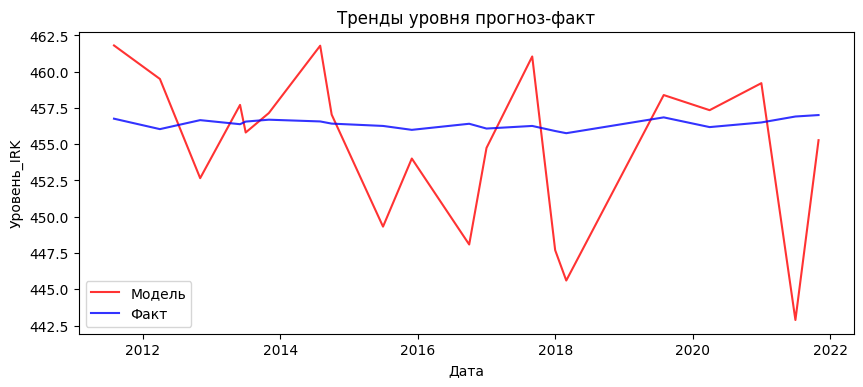

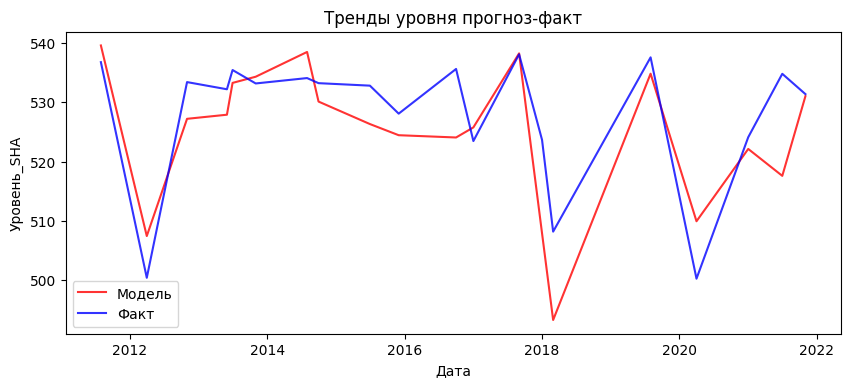

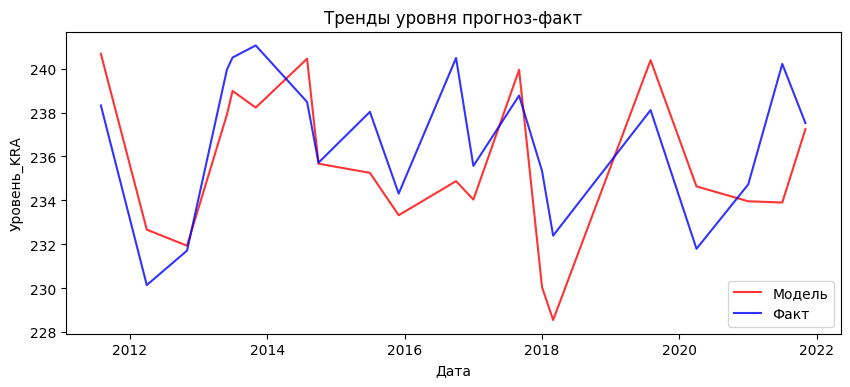

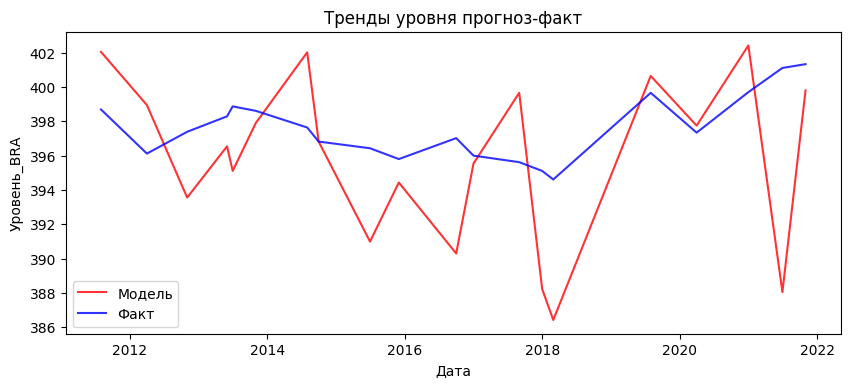

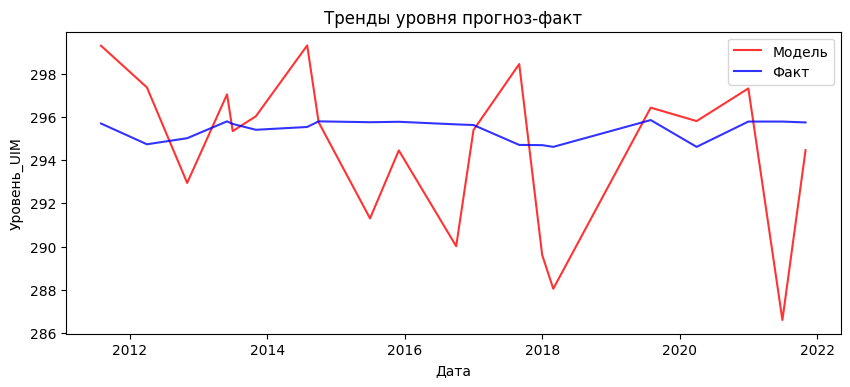

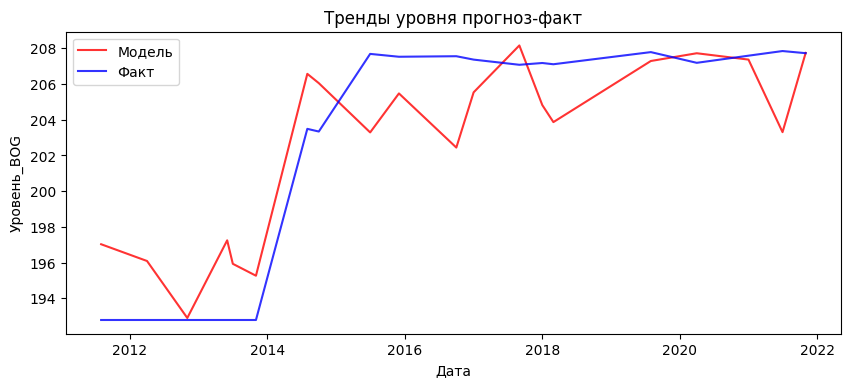

In [25]:
for col in GES_uroven:
    plt.subplots(figsize=(10,4), dpi=100);
    sns.lineplot(y=model_cat_uroven[col].predict(X_test_uroven), x=X_test_uroven.index, label='Модель', color='Red', alpha=0.8);
    sns.lineplot(y=y_test_uroven[col], x=X_test_uroven.index, label='Факт', color='Blue', alpha=0.8);
    plt.title('Тренды уровня прогноз-факт');
    plt.savefig(f'../data/Результаты моделирования/Уровень/{current_date} Модель для {col}.png', dpi=200);
    plt.show()

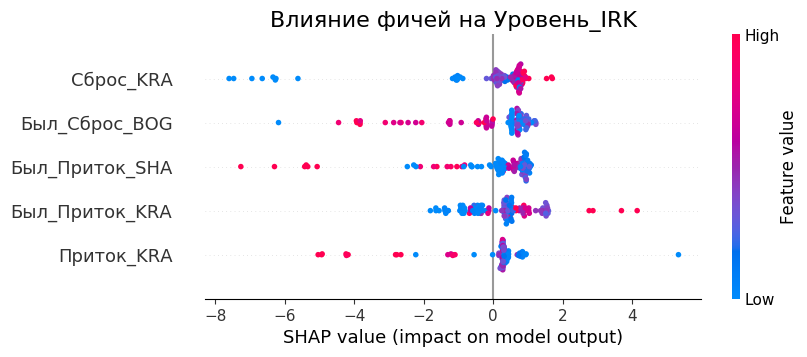

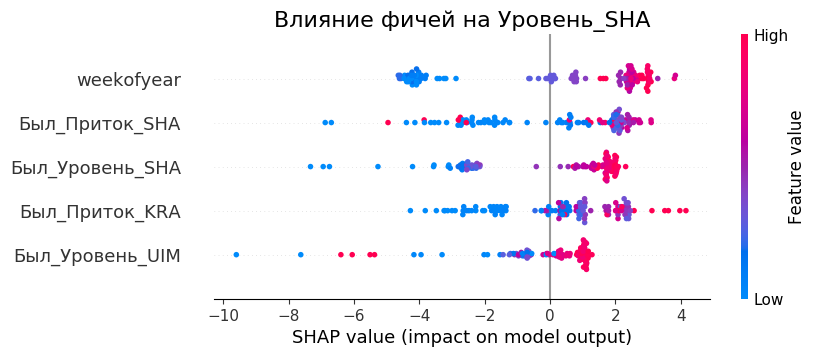

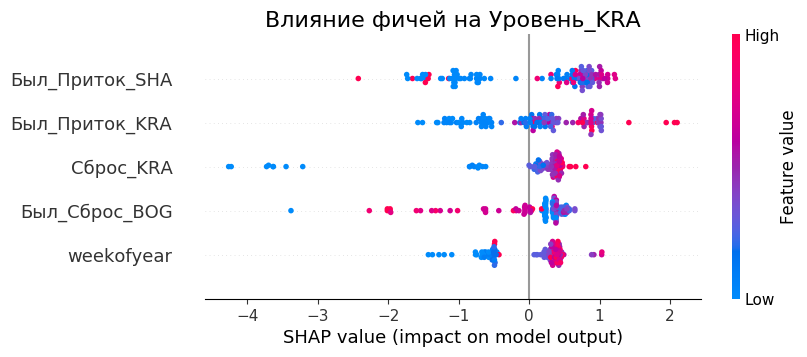

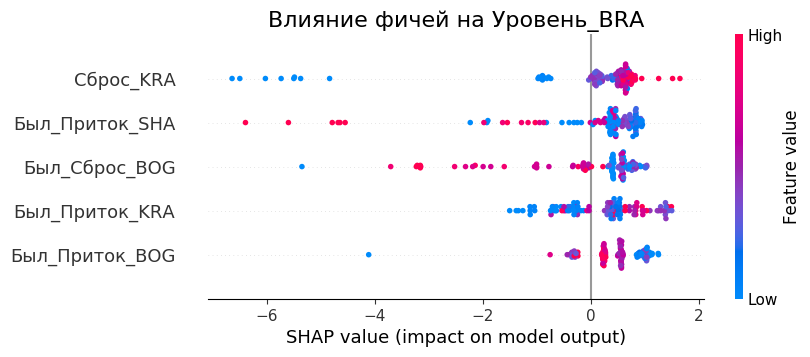

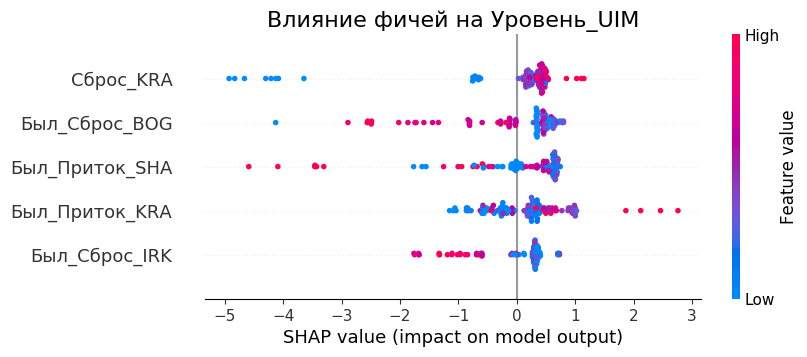

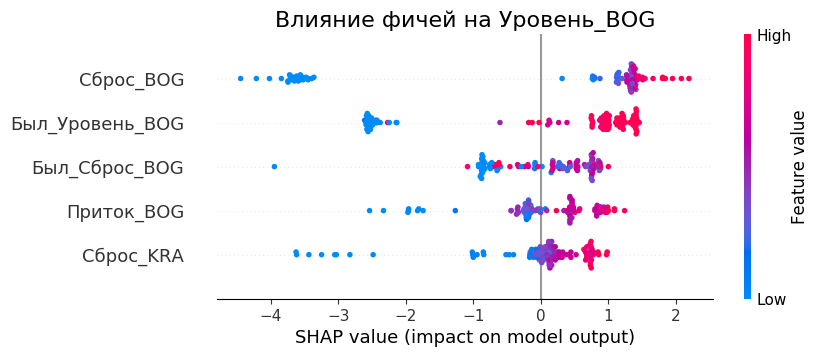

In [26]:
#Посмотрим на влияние фичей
for col in GES_uroven:
    fig, axes = plt.subplots(figsize=(6,4), dpi=100);
    shap.summary_plot(shap_values_uroven[col], X_train_uroven, show=False, max_display=5);
    plt.title(f'Влияние фичей на {col}', size=16);
    plt.savefig(f'../data/Результаты моделирования/Уровень/{current_date} Влияние фичей на {col}.png', dpi=200);
    plt.show();